# 중구 '명동거리' - 일반의류 모델링 (+ 상권정보)

In [1]:
import warnings
warnings.filterwarnings(action='ignore') 

import numpy as np
import pandas as pd
pd.set_option('display.float_format', lambda x: '%.2f' % x)

# 폰트 설정 방법 2
import matplotlib as plt
plt.rcParams["font.family"] = 'Haansoft Dotum'
plt.rcParams['axes.unicode_minus'] = False
%matplotlib inline
# 브라우저에서 바로 이미지를 그린다.

from sklearn import preprocessing
from sklearn.preprocessing import OneHotEncoder

import time
from xgboost import XGBRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

from sklearn.metrics import mean_squared_error

## 1. 데이터 불러오기

In [2]:
# 전처리 된 일반의류 데이터

df1 = pd.read_csv('./myungdong_cloth_after.csv', encoding = 'cp949')
df2 = pd.read_csv('./myungdong_all_after.csv', encoding = 'cp949')

In [3]:
# 결과 확인

df1.head()

,Unnamed: 0,기준_년_코드,기준_분기_코드,서비스_업종_코드,점포_수,유사_업종_점포_수,개업_율,개업_점포_수,폐업_률,폐업_점포_수,...,시간대_건수~21_매출_건수,시간대_건수~24_매출_건수,남성_매출_건수,여성_매출_건수,연령대_10_매출_건수,연령대_20_매출_건수,연령대_30_매출_건수,연령대_40_매출_건수,연령대_50_매출_건수,연령대_60_이상_매출_건수
0,0,2015,1,CS300011,1.00,1.00,0.50,0.90,4,0.82,...,0.78,0.74,0.75,0.73,0.80,0.75,0.73,0.67,0.73,0.39
1,1,2015,2,CS300011,0.96,0.96,0.50,0.60,2,0.33,...,0.90,0.92,0.89,0.90,0.80,0.89,0.97,0.85,0.91,0.57
2,2,2015,3,CS300011,0.86,0.86,0.50,0.70,3,0.70,...,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,0.67
3,3,2015,4,CS300011,0.84,0.84,0.50,0.70,2,0.33,...,0.70,0.76,0.71,0.69,0.87,0.69,0.66,0.74,0.69,0.42
4,4,2016,1,CS300011,0.75,0.75,0.50,0.70,3,0.64,...,0.64,0.60,0.57,0.63,0.69,0.62,0.57,0.55,0.61,0.42


In [4]:
df1.shape

(22, 82)

In [5]:
# 결측치 확인

df1.isnull().sum()

Unnamed: 0         0
기준_년_코드            0
기준_분기_코드           0
서비스_업종_코드          0
점포_수               0
                  ..
연령대_20_매출_건수       0
연령대_30_매출_건수       0
연령대_40_매출_건수       0
연령대_50_매출_건수       0
연령대_60_이상_매출_건수    0
Length: 82, dtype: int64

In [6]:
# 전체 결측치 확인

all_null = df1.isnull().sum()
all_null.sum()

0

In [14]:
# 모든 column 출력

df1.columns

Index(['Unnamed: 0', '기준_년_코드', '기준_분기_코드', '서비스_업종_코드', '점포_수', '유사_업종_점포_수',
       '개업_율', '개업_점포_수', '폐업_률', '폐업_점포_수', '프랜차이즈_점포_수', '당월_매출_금액',
       '당월_매출_건수', '주중_매출_비율', '주말_매출_비율', '월요일_매출_비율', '화요일_매출_비율',
       '수요일_매출_비율', '목요일_매출_비율', '금요일_매출_비율', '토요일_매출_비율', '일요일_매출_비율',
       '시간대_00~06_매출_비율', '시간대_06~11_매출_비율', '시간대_11~14_매출_비율',
       '시간대_14~17_매출_비율', '시간대_17~21_매출_비율', '시간대_21~24_매출_비율', '남성_매출_비율',
       '여성_매출_비율', '연령대_10_매출_비율', '연령대_20_매출_비율', '연령대_30_매출_비율',
       '연령대_40_매출_비율', '연령대_50_매출_비율', '연령대_60_이상_매출_비율', '주중_매출_금액',
       '주말_매출_금액', '월요일_매출_금액', '화요일_매출_금액', '수요일_매출_금액', '목요일_매출_금액',
       '금요일_매출_금액', '토요일_매출_금액', '일요일_매출_금액', '시간대_00~06_매출_금액',
       '시간대_06~11_매출_금액', '시간대_11~14_매출_금액', '시간대_14~17_매출_금액',
       '시간대_17~21_매출_금액', '시간대_21~24_매출_금액', '남성_매출_금액', '여성_매출_금액',
       '연령대_10_매출_금액', '연령대_20_매출_금액', '연령대_30_매출_금액', '연령대_40_매출_금액',
       '연령대_50_매출_금액', '연령대_60_이상_매출_금액', '주중_매출_건수', '주말_매출_건수', '월요일_매출_건수',
       '화요일_매

In [26]:
# 필요한 column 추출

use = ['기준_년_코드', '기준_분기_코드', '서비스_업종_코드', '점포_수', '당월_매출_금액',
          '주중_매출_금액','주말_매출_금액', '월요일_매출_금액', '화요일_매출_금액', '수요일_매출_금액', '목요일_매출_금액',
       '금요일_매출_금액', '토요일_매출_금액', '일요일_매출_금액', '시간대_00~06_매출_금액',
       '시간대_06~11_매출_금액', '시간대_11~14_매출_금액', '시간대_14~17_매출_금액',
       '시간대_17~21_매출_금액', '시간대_21~24_매출_금액', '남성_매출_금액', '여성_매출_금액',
       '연령대_10_매출_금액', '연령대_20_매출_금액', '연령대_30_매출_금액', '연령대_40_매출_금액',
       '연령대_50_매출_금액', '연령대_60_이상_매출_금액', '폐업_률']

df1_new = df1[use]

In [27]:
# 결과 확인

df1_new

,기준_년_코드,기준_분기_코드,서비스_업종_코드,점포_수,당월_매출_금액,주중_매출_금액,주말_매출_금액,월요일_매출_금액,화요일_매출_금액,수요일_매출_금액,...,시간대_21~24_매출_금액,남성_매출_금액,여성_매출_금액,연령대_10_매출_금액,연령대_20_매출_금액,연령대_30_매출_금액,연령대_40_매출_금액,연령대_50_매출_금액,연령대_60_이상_매출_금액,폐업_률
0,2015,1,CS300011,1.00,1.00,0.94,1.00,0.88,0.90,0.80,...,0.90,0.96,0.93,0.95,0.98,0.90,0.86,0.94,0.61,4
1,2015,2,CS300011,0.96,0.96,0.95,0.89,0.98,0.96,0.86,...,0.96,0.89,0.97,0.74,0.94,1.00,0.90,0.89,0.70,2
2,2015,3,CS300011,0.86,0.98,1.00,0.86,1.00,1.00,1.00,...,0.97,0.91,1.00,0.90,1.00,0.95,0.93,0.90,0.55,3
3,2015,4,CS300011,0.84,1.00,1.00,0.91,0.83,0.94,0.90,...,1.00,1.00,0.95,1.00,0.97,0.92,1.00,1.00,0.65,2
4,2016,1,CS300011,0.75,0.80,0.80,0.72,0.69,0.84,0.81,...,0.71,0.70,0.76,0.72,0.73,0.74,0.73,0.72,0.62,3
5,2016,2,CS300011,0.74,0.64,0.64,0.58,0.67,0.58,0.54,...,0.72,0.54,0.67,0.56,0.63,0.58,0.61,0.61,0.60,1
6,2016,3,CS300011,0.65,0.57,0.58,0.50,0.59,0.54,0.54,...,0.66,0.48,0.59,0.61,0.61,0.46,0.47,0.46,0.54,4
7,2016,4,CS300011,0.64,0.63,0.60,0.62,0.62,0.60,0.53,...,0.67,0.62,0.60,0.70,0.64,0.49,0.60,0.64,0.51,2
8,2017,1,CS300011,0.49,0.48,0.50,0.42,0.51,0.51,0.49,...,0.48,0.49,0.46,0.51,0.50,0.41,0.39,0.48,0.51,5
9,2017,2,CS300011,0.44,0.63,0.60,0.60,0.60,0.58,0.53,...,0.60,0.60,0.61,0.49,0.61,0.58,0.58,0.58,0.76,3


In [28]:
# 결과 확인

df2.head()

,Unnamed: 0,기준_년_코드,기준_분기_코드,상권_코드,상권_코드_명,총_유동인구_수,남성_유동인구_수,여성_유동인구_수,연령대_10_유동인구_수,연령대_20_유동인구_수,...,남성연령대 60 이상 상주인구 수,여성연령대 10 상주인구 수,여성연령대 20 상주인구 수,여성연령대 30 상주인구 수,여성연령대 40 상주인구 수,여성연령대 50 상주인구 수,여성연령대 60 이상 상주인구 수,총 가구 수,아파트 가구 수,비 아파트 가구 수
0,0,2020,2,1001203,명동거리,0.00,0.00,0.00,0.00,0.00,...,1.00,0.57,0.62,0.03,0.04,0.11,0.04,0.96,0.00,0.96
1,1,2020,1,1001203,명동거리,0.04,0.03,0.05,0.18,0.06,...,1.00,0.57,0.62,0.03,0.04,0.11,0.04,0.96,0.00,0.96
2,2,2019,4,1001203,명동거리,0.18,0.13,0.23,0.92,0.25,...,1.00,0.57,0.62,0.03,0.04,0.11,0.04,0.96,0.00,0.96
3,3,2019,3,1001203,명동거리,0.17,0.12,0.21,0.84,0.26,...,0.81,0.57,0.69,0.07,0.05,0.11,0.04,0.91,0.00,0.91
4,4,2019,2,1001203,명동거리,0.14,0.10,0.19,0.82,0.21,...,0.81,0.57,0.69,0.07,0.05,0.11,0.04,0.91,0.00,0.91


In [29]:
# 결과 확인

df2.shape

(22, 73)

In [30]:
# 결측치 확인

df2.isnull().sum()

Unnamed: 0            0
기준_년_코드               0
기준_분기_코드              0
상권_코드                 0
상권_코드_명               0
                     ..
여성연령대 50 상주인구 수       0
여성연령대 60 이상 상주인구 수    0
총 가구 수                0
아파트 가구 수              0
비 아파트 가구 수            0
Length: 73, dtype: int64

In [31]:
# 전체 결측치 확인

all_null = df2.isnull().sum()
all_null.sum()

0

In [32]:
# 모든 column 출력

df2.columns

Index(['Unnamed: 0', '기준_년_코드', '기준_분기_코드', '상권_코드', '상권_코드_명', '총_유동인구_수',
       '남성_유동인구_수', '여성_유동인구_수', '연령대_10_유동인구_수', '연령대_20_유동인구_수',
       '연령대_30_유동인구_수', '연령대_40_유동인구_수', '연령대_50_유동인구_수', '연령대_60_이상_유동인구_수',
       '시간대_1_유동인구_수', '시간대_2_유동인구_수', '시간대_3_유동인구_수', '시간대_4_유동인구_수',
       '시간대_5_유동인구_수', '시간대_6_유동인구_수', '월요일_유동인구_수', '화요일_유동인구_수',
       '수요일_유동인구_수', '목요일_유동인구_수', '금요일_유동인구_수', '토요일_유동인구_수', '일요일_유동인구_수',
       '집객시설_수', '총_직장_인구_수', '남성_직장_인구_수', '여성_직장_인구_수', '연령대_10_직장_인구_수',
       '연령대_20_직장_인구_수', '연령대_30_직장_인구_수', '연령대_40_직장_인구_수', '연령대_50_직장_인구_수',
       '연령대_60_이상_직장_인구_수', '남성연령대_10_직장_인구_수', '남성연령대_20_직장_인구_수',
       '남성연령대_30_직장_인구_수', '남성연령대_40_직장_인구_수', '남성연령대_50_직장_인구_수',
       '남성연령대_60_이상_직장_인구_수', '여성연령대_10_직장_인구_수', '여성연령대_20_직장_인구_수',
       '여성연령대_30_직장_인구_수', '여성연령대_40_직장_인구_수', '여성연령대_50_직장_인구_수',
       '여성연령대_60_이상_직장_인구_수', '총 상주인구 수', '남성 상주인구 수', '여성 상주인구 수',
       '연령대 10 상주인구 수', '연령대 20 상주인구 수', '연령대 30 상주인구 수', '연령대 40 상주인

In [33]:
# 불필요한 column 삭제

useless = ['Unnamed: 0', '상권_코드', '상권_코드_명']

df2_new = df2.drop(useless, axis = 1)

In [34]:
# 결과 확인

df2_new

,기준_년_코드,기준_분기_코드,총_유동인구_수,남성_유동인구_수,여성_유동인구_수,연령대_10_유동인구_수,연령대_20_유동인구_수,연령대_30_유동인구_수,연령대_40_유동인구_수,연령대_50_유동인구_수,...,남성연령대 60 이상 상주인구 수,여성연령대 10 상주인구 수,여성연령대 20 상주인구 수,여성연령대 30 상주인구 수,여성연령대 40 상주인구 수,여성연령대 50 상주인구 수,여성연령대 60 이상 상주인구 수,총 가구 수,아파트 가구 수,비 아파트 가구 수
0,2020,2,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,...,1.00,0.57,0.62,0.03,0.04,0.11,0.04,0.96,0.00,0.96
1,2020,1,0.04,0.03,0.05,0.18,0.06,0.01,0.02,0.02,...,1.00,0.57,0.62,0.03,0.04,0.11,0.04,0.96,0.00,0.96
2,2019,4,0.18,0.13,0.23,0.92,0.25,0.09,0.09,0.12,...,1.00,0.57,0.62,0.03,0.04,0.11,0.04,0.96,0.00,0.96
3,2019,3,0.17,0.12,0.21,0.84,0.26,0.09,0.09,0.10,...,0.81,0.57,0.69,0.07,0.05,0.11,0.04,0.91,0.00,0.91
4,2019,2,0.14,0.10,0.19,0.82,0.21,0.07,0.07,0.08,...,0.81,0.57,0.69,0.07,0.05,0.11,0.04,0.91,0.00,0.91
5,2019,1,0.14,0.10,0.18,0.71,0.22,0.07,0.07,0.08,...,0.81,0.57,0.69,0.07,0.05,0.11,0.04,0.91,0.00,0.91
6,2018,4,0.19,0.09,0.31,0.46,0.57,0.12,0.03,0.11,...,0.81,0.57,0.69,0.07,0.05,0.11,0.04,0.91,0.00,0.91
7,2018,3,0.30,0.18,0.43,0.54,0.79,0.22,0.11,0.17,...,0.78,0.57,0.77,0.10,0.05,0.10,0.04,1.00,0.00,1.00
8,2018,2,0.29,0.15,0.45,0.54,0.76,0.23,0.10,0.17,...,0.78,0.57,0.77,0.10,0.05,0.10,0.04,1.00,0.00,1.00
9,2018,1,0.26,0.12,0.42,0.67,0.74,0.19,0.07,0.13,...,0.22,0.14,0.08,0.00,0.00,0.00,0.03,0.21,0.00,0.21


In [35]:
# 업종별 데이터 + 상권별 데이터

total = pd.merge(df1_new, df2_new, how = 'left', on = ['기준_년_코드', '기준_분기_코드'])

In [49]:
# 결과 확인

total

,기준_년_코드,기준_분기_코드,서비스_업종_코드,점포_수,당월_매출_금액,주중_매출_금액,주말_매출_금액,월요일_매출_금액,화요일_매출_금액,수요일_매출_금액,...,남성연령대 60 이상 상주인구 수,여성연령대 10 상주인구 수,여성연령대 20 상주인구 수,여성연령대 30 상주인구 수,여성연령대 40 상주인구 수,여성연령대 50 상주인구 수,여성연령대 60 이상 상주인구 수,총 가구 수,아파트 가구 수,비 아파트 가구 수
0,2015,1,CS300011,1.00,1.00,0.94,1.00,0.88,0.90,0.80,...,0.00,0.00,0.00,0.03,0.00,0.08,0.00,0.00,0.00,0.00
1,2015,2,CS300011,0.96,0.96,0.95,0.89,0.98,0.96,0.86,...,0.19,0.43,0.15,0.03,0.02,0.06,0.02,0.26,0.00,0.26
2,2015,3,CS300011,0.86,0.98,1.00,0.86,1.00,1.00,1.00,...,0.19,0.43,0.15,0.03,0.02,0.06,0.02,0.26,0.00,0.26
3,2015,4,CS300011,0.84,1.00,1.00,0.91,0.83,0.94,0.90,...,0.19,0.43,0.15,0.03,0.02,0.04,0.02,0.25,0.00,0.25
4,2016,1,CS300011,0.75,0.80,0.80,0.72,0.69,0.84,0.81,...,0.19,0.43,0.15,0.03,0.02,0.04,0.02,0.25,0.00,0.25
5,2016,2,CS300011,0.74,0.64,0.64,0.58,0.67,0.58,0.54,...,0.63,1.00,1.00,0.97,1.00,0.99,1.00,0.80,0.00,0.80
6,2016,3,CS300011,0.65,0.57,0.58,0.50,0.59,0.54,0.54,...,0.63,1.00,1.00,0.97,1.00,0.99,1.00,0.80,0.00,0.80
7,2016,4,CS300011,0.64,0.63,0.60,0.62,0.62,0.60,0.53,...,0.70,1.00,0.92,1.00,0.99,1.00,1.00,0.89,0.00,0.89
8,2017,1,CS300011,0.49,0.48,0.50,0.42,0.51,0.51,0.49,...,0.70,1.00,0.92,1.00,0.99,1.00,1.00,0.89,0.00,0.89
9,2017,2,CS300011,0.44,0.63,0.60,0.60,0.60,0.58,0.53,...,0.74,0.57,0.54,0.15,0.05,0.13,0.05,0.96,0.00,0.96


In [37]:
# 전체 결측치 확인

all_null = total.isnull().sum()
all_null.sum()

0

In [38]:
# 결과 저장

# total.to_csv('./myungdong_all_after_merge.csv', encoding = 'cp949')

## 2. 모델링 데이터 준비
### (1) 인풋 데이터

In [139]:
total = pd.read_csv('./myungdong_cloth_after.csv', encoding = 'cp949')

total


,Unnamed: 0,기준_년_코드,기준_분기_코드,서비스_업종_코드,점포_수,유사_업종_점포_수,개업_율,개업_점포_수,폐업_률,폐업_점포_수,...,시간대_건수~21_매출_건수,시간대_건수~24_매출_건수,남성_매출_건수,여성_매출_건수,연령대_10_매출_건수,연령대_20_매출_건수,연령대_30_매출_건수,연령대_40_매출_건수,연령대_50_매출_건수,연령대_60_이상_매출_건수
0,0,2015,1,CS300011,1.00,1.00,0.50,0.90,4,0.82,...,0.78,0.74,0.75,0.73,0.80,0.75,0.73,0.67,0.73,0.39
1,1,2015,2,CS300011,0.96,0.96,0.50,0.60,2,0.33,...,0.90,0.92,0.89,0.90,0.80,0.89,0.97,0.85,0.91,0.57
2,2,2015,3,CS300011,0.86,0.86,0.50,0.70,3,0.70,...,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,0.67
3,3,2015,4,CS300011,0.84,0.84,0.50,0.70,2,0.33,...,0.70,0.76,0.71,0.69,0.87,0.69,0.66,0.74,0.69,0.42
4,4,2016,1,CS300011,0.75,0.75,0.50,0.70,3,0.64,...,0.64,0.60,0.57,0.63,0.69,0.62,0.57,0.55,0.61,0.42
5,5,2016,2,CS300011,0.74,0.74,0.50,0.80,1,0.24,...,0.64,0.71,0.59,0.68,0.66,0.66,0.62,0.62,0.69,0.53
6,6,2016,3,CS300011,0.65,0.65,1.00,1.00,4,0.76,...,0.62,0.70,0.54,0.64,0.70,0.64,0.54,0.54,0.58,0.44
7,7,2016,4,CS300011,0.64,0.64,1.00,1.00,2,0.33,...,0.46,0.53,0.43,0.49,0.56,0.47,0.41,0.47,0.48,0.38
8,8,2017,1,CS300011,0.49,0.48,0.50,0.80,5,1.00,...,0.41,0.41,0.41,0.42,0.42,0.42,0.39,0.38,0.46,0.49
9,9,2017,2,CS300011,0.44,0.44,0.50,0.90,3,0.48,...,0.56,0.59,0.57,0.62,0.48,0.57,0.62,0.65,0.74,0.86


In [142]:
total = total.drop(['Unnamed: 0', '유사_업종_점포_수', '개업_율', '개업_점포_수', '폐업_점포_수', '프랜차이즈_점포_수', '당월_매출_건수',
          '주중_매출_금액', '점포_수',
       '주말_매출_금액', '월요일_매출_금액', '화요일_매출_금액', '수요일_매출_금액', '목요일_매출_금액',
       '금요일_매출_금액', '토요일_매출_금액', '일요일_매출_금액', '시간대_00~06_매출_금액',
       '시간대_06~11_매출_금액', '시간대_11~14_매출_금액', '시간대_14~17_매출_금액',
       '시간대_17~21_매출_금액', '시간대_21~24_매출_금액', '남성_매출_금액', '여성_매출_금액',
       '연령대_10_매출_금액', '연령대_20_매출_금액', '연령대_30_매출_금액', '연령대_40_매출_금액',
       '연령대_50_매출_금액', '연령대_60_이상_매출_금액', '주중_매출_건수', '주말_매출_건수', '월요일_매출_건수',
       '화요일_매출_건수', '수요일_매출_건수', '목요일_매출_건수', '금요일_매출_건수', '토요일_매출_건수',
       '일요일_매출_건수', '시간대_건수~06_매출_건수', '시간대_건수~11_매출_건수', '시간대_건수~14_매출_건수',
       '시간대_건수~17_매출_건수', '시간대_건수~21_매출_건수', '시간대_건수~24_매출_건수', '남성_매출_건수',
       '여성_매출_건수', '연령대_10_매출_건수', '연령대_20_매출_건수', '연령대_30_매출_건수',
       '연령대_40_매출_건수', '연령대_50_매출_건수', '연령대_60_이상_매출_건수'], axis = 1)

In [143]:
# 예측을 위한 인풋 데이터 생성

a = total[total['기준_년_코드'] == 2020].drop('폐업_률', axis = 1)
b = a[a['기준_분기_코드'] == 2]
x_predict_2020_2 = b
x_predict_2020_2 = x_predict_2020_2.drop(['기준_년_코드', '기준_분기_코드', '서비스_업종_코드'], axis = 1)

In [144]:
x_predict_2020_2

,당월_매출_금액,주중_매출_비율,주말_매출_비율,월요일_매출_비율,화요일_매출_비율,수요일_매출_비율,목요일_매출_비율,금요일_매출_비율,토요일_매출_비율,일요일_매출_비율,...,시간대_17~21_매출_비율,시간대_21~24_매출_비율,남성_매출_비율,여성_매출_비율,연령대_10_매출_비율,연령대_20_매출_비율,연령대_30_매출_비율,연령대_40_매출_비율,연령대_50_매출_비율,연령대_60_이상_매출_비율
20,0.10,0.83,0.33,0.25,0.60,0.50,0.75,0.50,0.20,0.33,...,0.83,0.00,0.50,0.46,0.00,0.00,0.67,0.80,1.00,0.86


In [145]:
# 학습 데이터

x_in = total.drop(20).reset_index(drop = True).drop(['기준_년_코드', '기준_분기_코드','서비스_업종_코드', '폐업_률'], axis = 1)
x_in

,당월_매출_금액,주중_매출_비율,주말_매출_비율,월요일_매출_비율,화요일_매출_비율,수요일_매출_비율,목요일_매출_비율,금요일_매출_비율,토요일_매출_비율,일요일_매출_비율,...,시간대_17~21_매출_비율,시간대_21~24_매출_비율,남성_매출_비율,여성_매출_비율,연령대_10_매출_비율,연령대_20_매출_비율,연령대_30_매출_비율,연령대_40_매출_비율,연령대_50_매출_비율,연령대_60_이상_매출_비율
0,1.00,0.17,0.83,0.00,0.20,1.00,0.00,1.00,0.40,0.67,...,1.00,0.86,0.75,0.23,1.00,0.92,0.50,0.20,0.25,0.29
1,0.96,0.00,1.00,0.25,0.40,0.50,0.25,0.25,1.00,0.33,...,0.83,1.00,0.67,0.31,0.75,0.69,0.83,0.60,0.12,0.29
2,0.98,0.83,0.17,0.25,0.40,1.00,0.75,0.25,0.20,0.33,...,0.50,0.86,0.92,0.08,0.75,0.77,1.00,0.40,0.25,0.00
3,1.00,0.33,0.67,0.25,0.20,0.50,0.75,0.50,0.40,0.67,...,0.50,0.86,1.00,0.00,1.00,0.85,0.50,0.60,0.00,0.14
4,0.80,0.17,0.83,0.25,0.40,0.50,0.25,0.25,0.60,0.67,...,0.50,0.71,0.75,0.23,1.00,0.77,0.50,0.40,0.12,0.43
5,0.64,0.17,1.00,0.25,0.00,0.00,0.50,0.50,0.60,1.00,...,0.50,0.86,0.67,0.31,0.75,0.69,0.50,0.40,0.50,0.43
6,0.57,0.67,0.50,1.00,0.20,0.50,0.25,0.75,0.20,0.67,...,0.33,1.00,0.25,0.69,0.75,0.85,0.17,0.00,0.25,0.71
7,0.63,0.17,0.83,0.25,0.20,0.00,1.00,0.00,0.60,0.67,...,0.17,1.00,0.33,0.62,0.75,0.77,0.50,0.40,0.38,0.29
8,0.48,0.50,0.50,0.25,0.40,0.50,0.50,0.50,0.00,1.00,...,0.33,0.71,0.33,0.62,0.75,0.62,0.50,0.20,0.38,0.71
9,0.63,0.33,0.83,0.25,0.20,1.00,0.50,0.25,0.40,1.00,...,0.00,0.71,0.33,0.62,0.50,0.54,0.50,0.40,0.38,0.86


In [146]:
# 폐업률 데이터만 추출

myungdong = total[['기준_년_코드', '기준_분기_코드', '폐업_률']]

# 결과 확인

myungdong

,기준_년_코드,기준_분기_코드,폐업_률
0,2015,1,4
1,2015,2,2
2,2015,3,3
3,2015,4,2
4,2016,1,3
5,2016,2,1
6,2016,3,4
7,2016,4,2
8,2017,1,5
9,2017,2,3


In [147]:
a = myungdong[myungdong['기준_년_코드'] == 2020]
b = a[a['기준_분기_코드'] == 2]

y_predict_2020_2 = b.drop(['기준_년_코드', '기준_분기_코드'], axis = 1).reset_index(drop = True)
y_predict_2020_2

,폐업_률
0,0


In [148]:
x_out = myungdong.drop(20).drop(['기준_년_코드', '기준_분기_코드'], axis = 1).reset_index(drop = True)
x_out

,폐업_률
0,4
1,2
2,3
3,2
4,3
5,1
6,4
7,2
8,5
9,3


In [149]:
x_out['폐업_률'] = pd.to_numeric(x_out['폐업_률'])
x_out

,폐업_률
0,4
1,2
2,3
3,2
4,3
5,1
6,4
7,2
8,5
9,3


In [150]:
x = pd.concat([x_in,x_out], axis=1)
x

,당월_매출_금액,주중_매출_비율,주말_매출_비율,월요일_매출_비율,화요일_매출_비율,수요일_매출_비율,목요일_매출_비율,금요일_매출_비율,토요일_매출_비율,일요일_매출_비율,...,시간대_21~24_매출_비율,남성_매출_비율,여성_매출_비율,연령대_10_매출_비율,연령대_20_매출_비율,연령대_30_매출_비율,연령대_40_매출_비율,연령대_50_매출_비율,연령대_60_이상_매출_비율,폐업_률
0,1.00,0.17,0.83,0.00,0.20,1.00,0.00,1.00,0.40,0.67,...,0.86,0.75,0.23,1.00,0.92,0.50,0.20,0.25,0.29,4
1,0.96,0.00,1.00,0.25,0.40,0.50,0.25,0.25,1.00,0.33,...,1.00,0.67,0.31,0.75,0.69,0.83,0.60,0.12,0.29,2
2,0.98,0.83,0.17,0.25,0.40,1.00,0.75,0.25,0.20,0.33,...,0.86,0.92,0.08,0.75,0.77,1.00,0.40,0.25,0.00,3
3,1.00,0.33,0.67,0.25,0.20,0.50,0.75,0.50,0.40,0.67,...,0.86,1.00,0.00,1.00,0.85,0.50,0.60,0.00,0.14,2
4,0.80,0.17,0.83,0.25,0.40,0.50,0.25,0.25,0.60,0.67,...,0.71,0.75,0.23,1.00,0.77,0.50,0.40,0.12,0.43,3
5,0.64,0.17,1.00,0.25,0.00,0.00,0.50,0.50,0.60,1.00,...,0.86,0.67,0.31,0.75,0.69,0.50,0.40,0.50,0.43,1
6,0.57,0.67,0.50,1.00,0.20,0.50,0.25,0.75,0.20,0.67,...,1.00,0.25,0.69,0.75,0.85,0.17,0.00,0.25,0.71,4
7,0.63,0.17,0.83,0.25,0.20,0.00,1.00,0.00,0.60,0.67,...,1.00,0.33,0.62,0.75,0.77,0.50,0.40,0.38,0.29,2
8,0.48,0.50,0.50,0.25,0.40,0.50,0.50,0.50,0.00,1.00,...,0.71,0.33,0.62,0.75,0.62,0.50,0.20,0.38,0.71,5
9,0.63,0.33,0.83,0.25,0.20,1.00,0.50,0.25,0.40,1.00,...,0.71,0.33,0.62,0.50,0.54,0.50,0.40,0.38,0.86,3


## 3. 모델링 - XGBoost

In [151]:
import time
from xgboost import XGBRegressor
from sklearn.model_selection import train_test_split
start = time.time()  # 시작 시간 저장
from sklearn.metrics import accuracy_score

# train, test 데이터 분할

X_train, X_test, y_train, y_test= train_test_split(x_in, x_out, test_size=0.2, random_state=42)

In [152]:
# xgboost 학습

model = XGBRegressor(booster="gbtree", objective ='reg:squarederror', n_estimators=6000, learning_rate=0.001 ,
                      max_depth=12, n_jobs = -1,subsample=0.75, reg_lambda=1, colsample_bytree=1, gamma=0, )

eval_set = [(X_test, y_test)]

model.fit(X_train,y_train, eval_set=eval_set, verbose=True)

pred_y = model.predict(X_test)

#predictions = [round(value) for value in xgb_5000_명동_pred ]
# evaluate predictions

print("time :", time.time() - start)  # 현재시각 - 시작시간 = 실행 시간

[0]	validation_0-rmse:2.80049
[1]	validation_0-rmse:2.79889
[2]	validation_0-rmse:2.79747
[3]	validation_0-rmse:2.79598
[4]	validation_0-rmse:2.79460
[5]	validation_0-rmse:2.79319
[6]	validation_0-rmse:2.79167
[7]	validation_0-rmse:2.79035
[8]	validation_0-rmse:2.78891
[9]	validation_0-rmse:2.78780
[10]	validation_0-rmse:2.78637
[11]	validation_0-rmse:2.78479
[12]	validation_0-rmse:2.78341
[13]	validation_0-rmse:2.78165
[14]	validation_0-rmse:2.78025
[15]	validation_0-rmse:2.77887
[16]	validation_0-rmse:2.77721
[17]	validation_0-rmse:2.77564
[18]	validation_0-rmse:2.77402
[19]	validation_0-rmse:2.77264
[20]	validation_0-rmse:2.77113
[21]	validation_0-rmse:2.76974
[22]	validation_0-rmse:2.76814
[23]	validation_0-rmse:2.76688
[24]	validation_0-rmse:2.76556
[25]	validation_0-rmse:2.76467
[26]	validation_0-rmse:2.76326
[27]	validation_0-rmse:2.76187
[28]	validation_0-rmse:2.76049
[29]	validation_0-rmse:2.75966
[30]	validation_0-rmse:2.75842
[31]	validation_0-rmse:2.75710
[32]	validation_0-

[260]	validation_0-rmse:2.47467
[261]	validation_0-rmse:2.47404
[262]	validation_0-rmse:2.47280
[263]	validation_0-rmse:2.47165
[264]	validation_0-rmse:2.47028
[265]	validation_0-rmse:2.46927
[266]	validation_0-rmse:2.46810
[267]	validation_0-rmse:2.46732
[268]	validation_0-rmse:2.46631
[269]	validation_0-rmse:2.46525
[270]	validation_0-rmse:2.46408
[271]	validation_0-rmse:2.46296
[272]	validation_0-rmse:2.46176
[273]	validation_0-rmse:2.46103
[274]	validation_0-rmse:2.45982
[275]	validation_0-rmse:2.45863
[276]	validation_0-rmse:2.45740
[277]	validation_0-rmse:2.45609
[278]	validation_0-rmse:2.45495
[279]	validation_0-rmse:2.45376
[280]	validation_0-rmse:2.45276
[281]	validation_0-rmse:2.45154
[282]	validation_0-rmse:2.45050
[283]	validation_0-rmse:2.44897
[284]	validation_0-rmse:2.44793
[285]	validation_0-rmse:2.44662
[286]	validation_0-rmse:2.44530
[287]	validation_0-rmse:2.44416
[288]	validation_0-rmse:2.44302
[289]	validation_0-rmse:2.44241
[290]	validation_0-rmse:2.44144
[291]	va

[517]	validation_0-rmse:2.22899
[518]	validation_0-rmse:2.22821
[519]	validation_0-rmse:2.22702
[520]	validation_0-rmse:2.22628
[521]	validation_0-rmse:2.22549
[522]	validation_0-rmse:2.22439
[523]	validation_0-rmse:2.22379
[524]	validation_0-rmse:2.22289
[525]	validation_0-rmse:2.22193
[526]	validation_0-rmse:2.22087
[527]	validation_0-rmse:2.21992
[528]	validation_0-rmse:2.21937
[529]	validation_0-rmse:2.21854
[530]	validation_0-rmse:2.21750
[531]	validation_0-rmse:2.21666
[532]	validation_0-rmse:2.21589
[533]	validation_0-rmse:2.21512
[534]	validation_0-rmse:2.21392
[535]	validation_0-rmse:2.21354
[536]	validation_0-rmse:2.21278
[537]	validation_0-rmse:2.21246
[538]	validation_0-rmse:2.21162
[539]	validation_0-rmse:2.21059
[540]	validation_0-rmse:2.20999
[541]	validation_0-rmse:2.20921
[542]	validation_0-rmse:2.20873
[543]	validation_0-rmse:2.20774
[544]	validation_0-rmse:2.20682
[545]	validation_0-rmse:2.20565
[546]	validation_0-rmse:2.20453
[547]	validation_0-rmse:2.20370
[548]	va

[774]	validation_0-rmse:2.03740
[775]	validation_0-rmse:2.03725
[776]	validation_0-rmse:2.03652
[777]	validation_0-rmse:2.03575
[778]	validation_0-rmse:2.03509
[779]	validation_0-rmse:2.03435
[780]	validation_0-rmse:2.03376
[781]	validation_0-rmse:2.03296
[782]	validation_0-rmse:2.03247
[783]	validation_0-rmse:2.03196
[784]	validation_0-rmse:2.03097
[785]	validation_0-rmse:2.03023
[786]	validation_0-rmse:2.02962
[787]	validation_0-rmse:2.02907
[788]	validation_0-rmse:2.02823
[789]	validation_0-rmse:2.02776
[790]	validation_0-rmse:2.02708
[791]	validation_0-rmse:2.02642
[792]	validation_0-rmse:2.02564
[793]	validation_0-rmse:2.02490
[794]	validation_0-rmse:2.02424
[795]	validation_0-rmse:2.02363
[796]	validation_0-rmse:2.02301
[797]	validation_0-rmse:2.02216
[798]	validation_0-rmse:2.02167
[799]	validation_0-rmse:2.02089
[800]	validation_0-rmse:2.02034
[801]	validation_0-rmse:2.01962
[802]	validation_0-rmse:2.01915
[803]	validation_0-rmse:2.01837
[804]	validation_0-rmse:2.01814
[805]	va

[1030]	validation_0-rmse:1.88792
[1031]	validation_0-rmse:1.88728
[1032]	validation_0-rmse:1.88650
[1033]	validation_0-rmse:1.88591
[1034]	validation_0-rmse:1.88527
[1035]	validation_0-rmse:1.88488
[1036]	validation_0-rmse:1.88421
[1037]	validation_0-rmse:1.88348
[1038]	validation_0-rmse:1.88294
[1039]	validation_0-rmse:1.88237
[1040]	validation_0-rmse:1.88189
[1041]	validation_0-rmse:1.88133
[1042]	validation_0-rmse:1.88060
[1043]	validation_0-rmse:1.87987
[1044]	validation_0-rmse:1.87939
[1045]	validation_0-rmse:1.87889
[1046]	validation_0-rmse:1.87863
[1047]	validation_0-rmse:1.87817
[1048]	validation_0-rmse:1.87805
[1049]	validation_0-rmse:1.87750
[1050]	validation_0-rmse:1.87690
[1051]	validation_0-rmse:1.87655
[1052]	validation_0-rmse:1.87582
[1053]	validation_0-rmse:1.87515
[1054]	validation_0-rmse:1.87484
[1055]	validation_0-rmse:1.87436
[1056]	validation_0-rmse:1.87391
[1057]	validation_0-rmse:1.87343
[1058]	validation_0-rmse:1.87285
[1059]	validation_0-rmse:1.87247
[1060]	val

[1279]	validation_0-rmse:1.77014
[1280]	validation_0-rmse:1.76997
[1281]	validation_0-rmse:1.76934
[1282]	validation_0-rmse:1.76889
[1283]	validation_0-rmse:1.76826
[1284]	validation_0-rmse:1.76762
[1285]	validation_0-rmse:1.76721
[1286]	validation_0-rmse:1.76669
[1287]	validation_0-rmse:1.76646
[1288]	validation_0-rmse:1.76601
[1289]	validation_0-rmse:1.76558
[1290]	validation_0-rmse:1.76525
[1291]	validation_0-rmse:1.76492
[1292]	validation_0-rmse:1.76423
[1293]	validation_0-rmse:1.76382
[1294]	validation_0-rmse:1.76336
[1295]	validation_0-rmse:1.76279
[1296]	validation_0-rmse:1.76254
[1297]	validation_0-rmse:1.76212
[1298]	validation_0-rmse:1.76156
[1299]	validation_0-rmse:1.76120
[1300]	validation_0-rmse:1.76077
[1301]	validation_0-rmse:1.76016
[1302]	validation_0-rmse:1.75977
[1303]	validation_0-rmse:1.75909
[1304]	validation_0-rmse:1.75867
[1305]	validation_0-rmse:1.75843
[1306]	validation_0-rmse:1.75821
[1307]	validation_0-rmse:1.75810
[1308]	validation_0-rmse:1.75783
[1309]	val

[1528]	validation_0-rmse:1.67788
[1529]	validation_0-rmse:1.67781
[1530]	validation_0-rmse:1.67734
[1531]	validation_0-rmse:1.67699
[1532]	validation_0-rmse:1.67668
[1533]	validation_0-rmse:1.67641
[1534]	validation_0-rmse:1.67614
[1535]	validation_0-rmse:1.67586
[1536]	validation_0-rmse:1.67558
[1537]	validation_0-rmse:1.67520
[1538]	validation_0-rmse:1.67484
[1539]	validation_0-rmse:1.67454
[1540]	validation_0-rmse:1.67425
[1541]	validation_0-rmse:1.67399
[1542]	validation_0-rmse:1.67363
[1543]	validation_0-rmse:1.67327
[1544]	validation_0-rmse:1.67301
[1545]	validation_0-rmse:1.67259
[1546]	validation_0-rmse:1.67222
[1547]	validation_0-rmse:1.67172
[1548]	validation_0-rmse:1.67133
[1549]	validation_0-rmse:1.67111
[1550]	validation_0-rmse:1.67070
[1551]	validation_0-rmse:1.67063
[1552]	validation_0-rmse:1.67022
[1553]	validation_0-rmse:1.66990
[1554]	validation_0-rmse:1.66951
[1555]	validation_0-rmse:1.66913
[1556]	validation_0-rmse:1.66893
[1557]	validation_0-rmse:1.66858
[1558]	val

[1777]	validation_0-rmse:1.60381
[1778]	validation_0-rmse:1.60361
[1779]	validation_0-rmse:1.60343
[1780]	validation_0-rmse:1.60295
[1781]	validation_0-rmse:1.60268
[1782]	validation_0-rmse:1.60259
[1783]	validation_0-rmse:1.60217
[1784]	validation_0-rmse:1.60189
[1785]	validation_0-rmse:1.60174
[1786]	validation_0-rmse:1.60147
[1787]	validation_0-rmse:1.60140
[1788]	validation_0-rmse:1.60117
[1789]	validation_0-rmse:1.60092
[1790]	validation_0-rmse:1.60067
[1791]	validation_0-rmse:1.60048
[1792]	validation_0-rmse:1.60017
[1793]	validation_0-rmse:1.60001
[1794]	validation_0-rmse:1.59974
[1795]	validation_0-rmse:1.59964
[1796]	validation_0-rmse:1.59938
[1797]	validation_0-rmse:1.59930
[1798]	validation_0-rmse:1.59897
[1799]	validation_0-rmse:1.59884
[1800]	validation_0-rmse:1.59881
[1801]	validation_0-rmse:1.59856
[1802]	validation_0-rmse:1.59820
[1803]	validation_0-rmse:1.59800
[1804]	validation_0-rmse:1.59792
[1805]	validation_0-rmse:1.59766
[1806]	validation_0-rmse:1.59750
[1807]	val

[2026]	validation_0-rmse:1.55120
[2027]	validation_0-rmse:1.55083
[2028]	validation_0-rmse:1.55068
[2029]	validation_0-rmse:1.55032
[2030]	validation_0-rmse:1.55002
[2031]	validation_0-rmse:1.54996
[2032]	validation_0-rmse:1.54966
[2033]	validation_0-rmse:1.54936
[2034]	validation_0-rmse:1.54910
[2035]	validation_0-rmse:1.54903
[2036]	validation_0-rmse:1.54869
[2037]	validation_0-rmse:1.54845
[2038]	validation_0-rmse:1.54843
[2039]	validation_0-rmse:1.54818
[2040]	validation_0-rmse:1.54802
[2041]	validation_0-rmse:1.54781
[2042]	validation_0-rmse:1.54776
[2043]	validation_0-rmse:1.54747
[2044]	validation_0-rmse:1.54735
[2045]	validation_0-rmse:1.54717
[2046]	validation_0-rmse:1.54688
[2047]	validation_0-rmse:1.54656
[2048]	validation_0-rmse:1.54655
[2049]	validation_0-rmse:1.54637
[2050]	validation_0-rmse:1.54627
[2051]	validation_0-rmse:1.54616
[2052]	validation_0-rmse:1.54611
[2053]	validation_0-rmse:1.54589
[2054]	validation_0-rmse:1.54561
[2055]	validation_0-rmse:1.54557
[2056]	val

[2275]	validation_0-rmse:1.50659
[2276]	validation_0-rmse:1.50627
[2277]	validation_0-rmse:1.50602
[2278]	validation_0-rmse:1.50594
[2279]	validation_0-rmse:1.50573
[2280]	validation_0-rmse:1.50571
[2281]	validation_0-rmse:1.50547
[2282]	validation_0-rmse:1.50543
[2283]	validation_0-rmse:1.50528
[2284]	validation_0-rmse:1.50521
[2285]	validation_0-rmse:1.50493
[2286]	validation_0-rmse:1.50486
[2287]	validation_0-rmse:1.50481
[2288]	validation_0-rmse:1.50459
[2289]	validation_0-rmse:1.50443
[2290]	validation_0-rmse:1.50428
[2291]	validation_0-rmse:1.50419
[2292]	validation_0-rmse:1.50401
[2293]	validation_0-rmse:1.50392
[2294]	validation_0-rmse:1.50370
[2295]	validation_0-rmse:1.50343
[2296]	validation_0-rmse:1.50334
[2297]	validation_0-rmse:1.50329
[2298]	validation_0-rmse:1.50327
[2299]	validation_0-rmse:1.50310
[2300]	validation_0-rmse:1.50275
[2301]	validation_0-rmse:1.50252
[2302]	validation_0-rmse:1.50249
[2303]	validation_0-rmse:1.50232
[2304]	validation_0-rmse:1.50234
[2305]	val

[2524]	validation_0-rmse:1.47135
[2525]	validation_0-rmse:1.47125
[2526]	validation_0-rmse:1.47118
[2527]	validation_0-rmse:1.47104
[2528]	validation_0-rmse:1.47091
[2529]	validation_0-rmse:1.47079
[2530]	validation_0-rmse:1.47063
[2531]	validation_0-rmse:1.47054
[2532]	validation_0-rmse:1.47039
[2533]	validation_0-rmse:1.47023
[2534]	validation_0-rmse:1.47017
[2535]	validation_0-rmse:1.47006
[2536]	validation_0-rmse:1.47001
[2537]	validation_0-rmse:1.46979
[2538]	validation_0-rmse:1.46964
[2539]	validation_0-rmse:1.46939
[2540]	validation_0-rmse:1.46909
[2541]	validation_0-rmse:1.46887
[2542]	validation_0-rmse:1.46861
[2543]	validation_0-rmse:1.46845
[2544]	validation_0-rmse:1.46842
[2545]	validation_0-rmse:1.46816
[2546]	validation_0-rmse:1.46808
[2547]	validation_0-rmse:1.46801
[2548]	validation_0-rmse:1.46788
[2549]	validation_0-rmse:1.46785
[2550]	validation_0-rmse:1.46772
[2551]	validation_0-rmse:1.46749
[2552]	validation_0-rmse:1.46742
[2553]	validation_0-rmse:1.46741
[2554]	val

[2773]	validation_0-rmse:1.44536
[2774]	validation_0-rmse:1.44518
[2775]	validation_0-rmse:1.44518
[2776]	validation_0-rmse:1.44512
[2777]	validation_0-rmse:1.44501
[2778]	validation_0-rmse:1.44491
[2779]	validation_0-rmse:1.44487
[2780]	validation_0-rmse:1.44479
[2781]	validation_0-rmse:1.44480
[2782]	validation_0-rmse:1.44475
[2783]	validation_0-rmse:1.44464
[2784]	validation_0-rmse:1.44464
[2785]	validation_0-rmse:1.44457
[2786]	validation_0-rmse:1.44440
[2787]	validation_0-rmse:1.44433
[2788]	validation_0-rmse:1.44426
[2789]	validation_0-rmse:1.44404
[2790]	validation_0-rmse:1.44386
[2791]	validation_0-rmse:1.44376
[2792]	validation_0-rmse:1.44374
[2793]	validation_0-rmse:1.44358
[2794]	validation_0-rmse:1.44324
[2795]	validation_0-rmse:1.44306
[2796]	validation_0-rmse:1.44308
[2797]	validation_0-rmse:1.44295
[2798]	validation_0-rmse:1.44288
[2799]	validation_0-rmse:1.44283
[2800]	validation_0-rmse:1.44270
[2801]	validation_0-rmse:1.44254
[2802]	validation_0-rmse:1.44243
[2803]	val

[3022]	validation_0-rmse:1.42246
[3023]	validation_0-rmse:1.42232
[3024]	validation_0-rmse:1.42229
[3025]	validation_0-rmse:1.42216
[3026]	validation_0-rmse:1.42217
[3027]	validation_0-rmse:1.42212
[3028]	validation_0-rmse:1.42204
[3029]	validation_0-rmse:1.42204
[3030]	validation_0-rmse:1.42201
[3031]	validation_0-rmse:1.42191
[3032]	validation_0-rmse:1.42176
[3033]	validation_0-rmse:1.42166
[3034]	validation_0-rmse:1.42161
[3035]	validation_0-rmse:1.42151
[3036]	validation_0-rmse:1.42148
[3037]	validation_0-rmse:1.42140
[3038]	validation_0-rmse:1.42134
[3039]	validation_0-rmse:1.42118
[3040]	validation_0-rmse:1.42116
[3041]	validation_0-rmse:1.42105
[3042]	validation_0-rmse:1.42092
[3043]	validation_0-rmse:1.42085
[3044]	validation_0-rmse:1.42076
[3045]	validation_0-rmse:1.42071
[3046]	validation_0-rmse:1.42073
[3047]	validation_0-rmse:1.42057
[3048]	validation_0-rmse:1.42044
[3049]	validation_0-rmse:1.42034
[3050]	validation_0-rmse:1.42022
[3051]	validation_0-rmse:1.42011
[3052]	val

[3271]	validation_0-rmse:1.40521
[3272]	validation_0-rmse:1.40518
[3273]	validation_0-rmse:1.40510
[3274]	validation_0-rmse:1.40502
[3275]	validation_0-rmse:1.40490
[3276]	validation_0-rmse:1.40481
[3277]	validation_0-rmse:1.40472
[3278]	validation_0-rmse:1.40466
[3279]	validation_0-rmse:1.40458
[3280]	validation_0-rmse:1.40447
[3281]	validation_0-rmse:1.40439
[3282]	validation_0-rmse:1.40432
[3283]	validation_0-rmse:1.40428
[3284]	validation_0-rmse:1.40420
[3285]	validation_0-rmse:1.40414
[3286]	validation_0-rmse:1.40402
[3287]	validation_0-rmse:1.40402
[3288]	validation_0-rmse:1.40387
[3289]	validation_0-rmse:1.40380
[3290]	validation_0-rmse:1.40367
[3291]	validation_0-rmse:1.40358
[3292]	validation_0-rmse:1.40355
[3293]	validation_0-rmse:1.40352
[3294]	validation_0-rmse:1.40345
[3295]	validation_0-rmse:1.40335
[3296]	validation_0-rmse:1.40323
[3297]	validation_0-rmse:1.40315
[3298]	validation_0-rmse:1.40312
[3299]	validation_0-rmse:1.40305
[3300]	validation_0-rmse:1.40297
[3301]	val

[3520]	validation_0-rmse:1.39170
[3521]	validation_0-rmse:1.39168
[3522]	validation_0-rmse:1.39162
[3523]	validation_0-rmse:1.39156
[3524]	validation_0-rmse:1.39153
[3525]	validation_0-rmse:1.39150
[3526]	validation_0-rmse:1.39147
[3527]	validation_0-rmse:1.39141
[3528]	validation_0-rmse:1.39131
[3529]	validation_0-rmse:1.39124
[3530]	validation_0-rmse:1.39112
[3531]	validation_0-rmse:1.39112
[3532]	validation_0-rmse:1.39108
[3533]	validation_0-rmse:1.39102
[3534]	validation_0-rmse:1.39100
[3535]	validation_0-rmse:1.39085
[3536]	validation_0-rmse:1.39084
[3537]	validation_0-rmse:1.39078
[3538]	validation_0-rmse:1.39071
[3539]	validation_0-rmse:1.39065
[3540]	validation_0-rmse:1.39064
[3541]	validation_0-rmse:1.39061
[3542]	validation_0-rmse:1.39054
[3543]	validation_0-rmse:1.39046
[3544]	validation_0-rmse:1.39046
[3545]	validation_0-rmse:1.39040
[3546]	validation_0-rmse:1.39027
[3547]	validation_0-rmse:1.39021
[3548]	validation_0-rmse:1.39023
[3549]	validation_0-rmse:1.39013
[3550]	val

[3769]	validation_0-rmse:1.38137
[3770]	validation_0-rmse:1.38133
[3771]	validation_0-rmse:1.38126
[3772]	validation_0-rmse:1.38125
[3773]	validation_0-rmse:1.38122
[3774]	validation_0-rmse:1.38114
[3775]	validation_0-rmse:1.38114
[3776]	validation_0-rmse:1.38108
[3777]	validation_0-rmse:1.38107
[3778]	validation_0-rmse:1.38097
[3779]	validation_0-rmse:1.38092
[3780]	validation_0-rmse:1.38085
[3781]	validation_0-rmse:1.38079
[3782]	validation_0-rmse:1.38076
[3783]	validation_0-rmse:1.38074
[3784]	validation_0-rmse:1.38069
[3785]	validation_0-rmse:1.38064
[3786]	validation_0-rmse:1.38062
[3787]	validation_0-rmse:1.38062
[3788]	validation_0-rmse:1.38064
[3789]	validation_0-rmse:1.38062
[3790]	validation_0-rmse:1.38060
[3791]	validation_0-rmse:1.38059
[3792]	validation_0-rmse:1.38052
[3793]	validation_0-rmse:1.38044
[3794]	validation_0-rmse:1.38039
[3795]	validation_0-rmse:1.38033
[3796]	validation_0-rmse:1.38025
[3797]	validation_0-rmse:1.38019
[3798]	validation_0-rmse:1.38014
[3799]	val

[4018]	validation_0-rmse:1.37271
[4019]	validation_0-rmse:1.37267
[4020]	validation_0-rmse:1.37262
[4021]	validation_0-rmse:1.37257
[4022]	validation_0-rmse:1.37257
[4023]	validation_0-rmse:1.37255
[4024]	validation_0-rmse:1.37249
[4025]	validation_0-rmse:1.37252
[4026]	validation_0-rmse:1.37251
[4027]	validation_0-rmse:1.37249
[4028]	validation_0-rmse:1.37244
[4029]	validation_0-rmse:1.37235
[4030]	validation_0-rmse:1.37235
[4031]	validation_0-rmse:1.37231
[4032]	validation_0-rmse:1.37225
[4033]	validation_0-rmse:1.37223
[4034]	validation_0-rmse:1.37218
[4035]	validation_0-rmse:1.37220
[4036]	validation_0-rmse:1.37223
[4037]	validation_0-rmse:1.37223
[4038]	validation_0-rmse:1.37217
[4039]	validation_0-rmse:1.37214
[4040]	validation_0-rmse:1.37213
[4041]	validation_0-rmse:1.37210
[4042]	validation_0-rmse:1.37207
[4043]	validation_0-rmse:1.37204
[4044]	validation_0-rmse:1.37207
[4045]	validation_0-rmse:1.37207
[4046]	validation_0-rmse:1.37203
[4047]	validation_0-rmse:1.37202
[4048]	val

[4267]	validation_0-rmse:1.36520
[4268]	validation_0-rmse:1.36523
[4269]	validation_0-rmse:1.36519
[4270]	validation_0-rmse:1.36512
[4271]	validation_0-rmse:1.36513
[4272]	validation_0-rmse:1.36510
[4273]	validation_0-rmse:1.36506
[4274]	validation_0-rmse:1.36503
[4275]	validation_0-rmse:1.36503
[4276]	validation_0-rmse:1.36502
[4277]	validation_0-rmse:1.36503
[4278]	validation_0-rmse:1.36501
[4279]	validation_0-rmse:1.36494
[4280]	validation_0-rmse:1.36491
[4281]	validation_0-rmse:1.36490
[4282]	validation_0-rmse:1.36488
[4283]	validation_0-rmse:1.36487
[4284]	validation_0-rmse:1.36484
[4285]	validation_0-rmse:1.36485
[4286]	validation_0-rmse:1.36486
[4287]	validation_0-rmse:1.36479
[4288]	validation_0-rmse:1.36479
[4289]	validation_0-rmse:1.36475
[4290]	validation_0-rmse:1.36475
[4291]	validation_0-rmse:1.36475
[4292]	validation_0-rmse:1.36477
[4293]	validation_0-rmse:1.36478
[4294]	validation_0-rmse:1.36479
[4295]	validation_0-rmse:1.36474
[4296]	validation_0-rmse:1.36476
[4297]	val

[4516]	validation_0-rmse:1.35910
[4517]	validation_0-rmse:1.35906
[4518]	validation_0-rmse:1.35907
[4519]	validation_0-rmse:1.35901
[4520]	validation_0-rmse:1.35898
[4521]	validation_0-rmse:1.35895
[4522]	validation_0-rmse:1.35892
[4523]	validation_0-rmse:1.35894
[4524]	validation_0-rmse:1.35887
[4525]	validation_0-rmse:1.35882
[4526]	validation_0-rmse:1.35880
[4527]	validation_0-rmse:1.35882
[4528]	validation_0-rmse:1.35878
[4529]	validation_0-rmse:1.35875
[4530]	validation_0-rmse:1.35872
[4531]	validation_0-rmse:1.35867
[4532]	validation_0-rmse:1.35864
[4533]	validation_0-rmse:1.35860
[4534]	validation_0-rmse:1.35860
[4535]	validation_0-rmse:1.35855
[4536]	validation_0-rmse:1.35856
[4537]	validation_0-rmse:1.35853
[4538]	validation_0-rmse:1.35851
[4539]	validation_0-rmse:1.35847
[4540]	validation_0-rmse:1.35849
[4541]	validation_0-rmse:1.35847
[4542]	validation_0-rmse:1.35844
[4543]	validation_0-rmse:1.35840
[4544]	validation_0-rmse:1.35840
[4545]	validation_0-rmse:1.35836
[4546]	val

[4765]	validation_0-rmse:1.35302
[4766]	validation_0-rmse:1.35298
[4767]	validation_0-rmse:1.35298
[4768]	validation_0-rmse:1.35301
[4769]	validation_0-rmse:1.35297
[4770]	validation_0-rmse:1.35294
[4771]	validation_0-rmse:1.35292
[4772]	validation_0-rmse:1.35290
[4773]	validation_0-rmse:1.35285
[4774]	validation_0-rmse:1.35281
[4775]	validation_0-rmse:1.35278
[4776]	validation_0-rmse:1.35280
[4777]	validation_0-rmse:1.35276
[4778]	validation_0-rmse:1.35276
[4779]	validation_0-rmse:1.35274
[4780]	validation_0-rmse:1.35271
[4781]	validation_0-rmse:1.35262
[4782]	validation_0-rmse:1.35257
[4783]	validation_0-rmse:1.35254
[4784]	validation_0-rmse:1.35251
[4785]	validation_0-rmse:1.35251
[4786]	validation_0-rmse:1.35251
[4787]	validation_0-rmse:1.35248
[4788]	validation_0-rmse:1.35248
[4789]	validation_0-rmse:1.35245
[4790]	validation_0-rmse:1.35242
[4791]	validation_0-rmse:1.35238
[4792]	validation_0-rmse:1.35235
[4793]	validation_0-rmse:1.35231
[4794]	validation_0-rmse:1.35227
[4795]	val

[5014]	validation_0-rmse:1.34817
[5015]	validation_0-rmse:1.34815
[5016]	validation_0-rmse:1.34812
[5017]	validation_0-rmse:1.34812
[5018]	validation_0-rmse:1.34810
[5019]	validation_0-rmse:1.34810
[5020]	validation_0-rmse:1.34808
[5021]	validation_0-rmse:1.34806
[5022]	validation_0-rmse:1.34804
[5023]	validation_0-rmse:1.34806
[5024]	validation_0-rmse:1.34804
[5025]	validation_0-rmse:1.34803
[5026]	validation_0-rmse:1.34801
[5027]	validation_0-rmse:1.34797
[5028]	validation_0-rmse:1.34793
[5029]	validation_0-rmse:1.34791
[5030]	validation_0-rmse:1.34788
[5031]	validation_0-rmse:1.34785
[5032]	validation_0-rmse:1.34785
[5033]	validation_0-rmse:1.34782
[5034]	validation_0-rmse:1.34780
[5035]	validation_0-rmse:1.34777
[5036]	validation_0-rmse:1.34774
[5037]	validation_0-rmse:1.34777
[5038]	validation_0-rmse:1.34774
[5039]	validation_0-rmse:1.34771
[5040]	validation_0-rmse:1.34769
[5041]	validation_0-rmse:1.34768
[5042]	validation_0-rmse:1.34765
[5043]	validation_0-rmse:1.34765
[5044]	val

[5263]	validation_0-rmse:1.34417
[5264]	validation_0-rmse:1.34418
[5265]	validation_0-rmse:1.34417
[5266]	validation_0-rmse:1.34417
[5267]	validation_0-rmse:1.34409
[5268]	validation_0-rmse:1.34407
[5269]	validation_0-rmse:1.34404
[5270]	validation_0-rmse:1.34401
[5271]	validation_0-rmse:1.34398
[5272]	validation_0-rmse:1.34396
[5273]	validation_0-rmse:1.34394
[5274]	validation_0-rmse:1.34394
[5275]	validation_0-rmse:1.34392
[5276]	validation_0-rmse:1.34391
[5277]	validation_0-rmse:1.34391
[5278]	validation_0-rmse:1.34389
[5279]	validation_0-rmse:1.34387
[5280]	validation_0-rmse:1.34387
[5281]	validation_0-rmse:1.34387
[5282]	validation_0-rmse:1.34387
[5283]	validation_0-rmse:1.34385
[5284]	validation_0-rmse:1.34383
[5285]	validation_0-rmse:1.34381
[5286]	validation_0-rmse:1.34380
[5287]	validation_0-rmse:1.34377
[5288]	validation_0-rmse:1.34376
[5289]	validation_0-rmse:1.34373
[5290]	validation_0-rmse:1.34373
[5291]	validation_0-rmse:1.34371
[5292]	validation_0-rmse:1.34368
[5293]	val

[5512]	validation_0-rmse:1.34056
[5513]	validation_0-rmse:1.34055
[5514]	validation_0-rmse:1.34054
[5515]	validation_0-rmse:1.34051
[5516]	validation_0-rmse:1.34051
[5517]	validation_0-rmse:1.34049
[5518]	validation_0-rmse:1.34050
[5519]	validation_0-rmse:1.34049
[5520]	validation_0-rmse:1.34049
[5521]	validation_0-rmse:1.34049
[5522]	validation_0-rmse:1.34047
[5523]	validation_0-rmse:1.34049
[5524]	validation_0-rmse:1.34049
[5525]	validation_0-rmse:1.34047
[5526]	validation_0-rmse:1.34044
[5527]	validation_0-rmse:1.34045
[5528]	validation_0-rmse:1.34043
[5529]	validation_0-rmse:1.34044
[5530]	validation_0-rmse:1.34044
[5531]	validation_0-rmse:1.34045
[5532]	validation_0-rmse:1.34045
[5533]	validation_0-rmse:1.34044
[5534]	validation_0-rmse:1.34042
[5535]	validation_0-rmse:1.34040
[5536]	validation_0-rmse:1.34037
[5537]	validation_0-rmse:1.34035
[5538]	validation_0-rmse:1.34033
[5539]	validation_0-rmse:1.34032
[5540]	validation_0-rmse:1.34032
[5541]	validation_0-rmse:1.34031
[5542]	val

[5761]	validation_0-rmse:1.33770
[5762]	validation_0-rmse:1.33768
[5763]	validation_0-rmse:1.33766
[5764]	validation_0-rmse:1.33765
[5765]	validation_0-rmse:1.33763
[5766]	validation_0-rmse:1.33764
[5767]	validation_0-rmse:1.33762
[5768]	validation_0-rmse:1.33760
[5769]	validation_0-rmse:1.33759
[5770]	validation_0-rmse:1.33759
[5771]	validation_0-rmse:1.33757
[5772]	validation_0-rmse:1.33757
[5773]	validation_0-rmse:1.33758
[5774]	validation_0-rmse:1.33758
[5775]	validation_0-rmse:1.33758
[5776]	validation_0-rmse:1.33756
[5777]	validation_0-rmse:1.33755
[5778]	validation_0-rmse:1.33755
[5779]	validation_0-rmse:1.33755
[5780]	validation_0-rmse:1.33754
[5781]	validation_0-rmse:1.33752
[5782]	validation_0-rmse:1.33752
[5783]	validation_0-rmse:1.33750
[5784]	validation_0-rmse:1.33749
[5785]	validation_0-rmse:1.33747
[5786]	validation_0-rmse:1.33746
[5787]	validation_0-rmse:1.33747
[5788]	validation_0-rmse:1.33746
[5789]	validation_0-rmse:1.33744
[5790]	validation_0-rmse:1.33743
[5791]	val

## 4. 모델링 결과 확인
### (1) 모델 성능 시각화

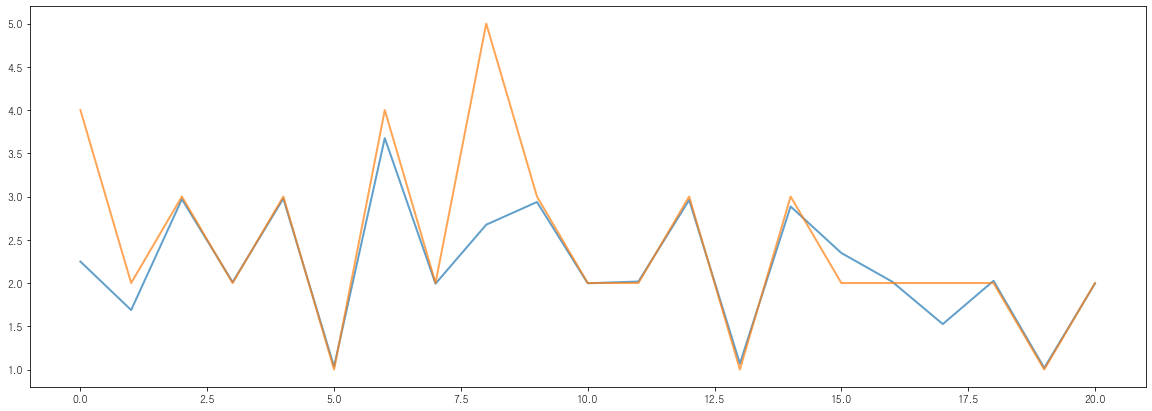

In [153]:
# 모델 성능 시각화

plt.pyplot.plot(model.predict(x_in),alpha = 0.7,linewidth = 2)
# 파란색 : 예측값
# 주황색 : 실제값
# 갈색 : 파란색과 주황색이 겹치는 부분
plt.pyplot.plot(x_out.values,alpha = 0.7,linewidth = 2)

### (2) Feature Importance

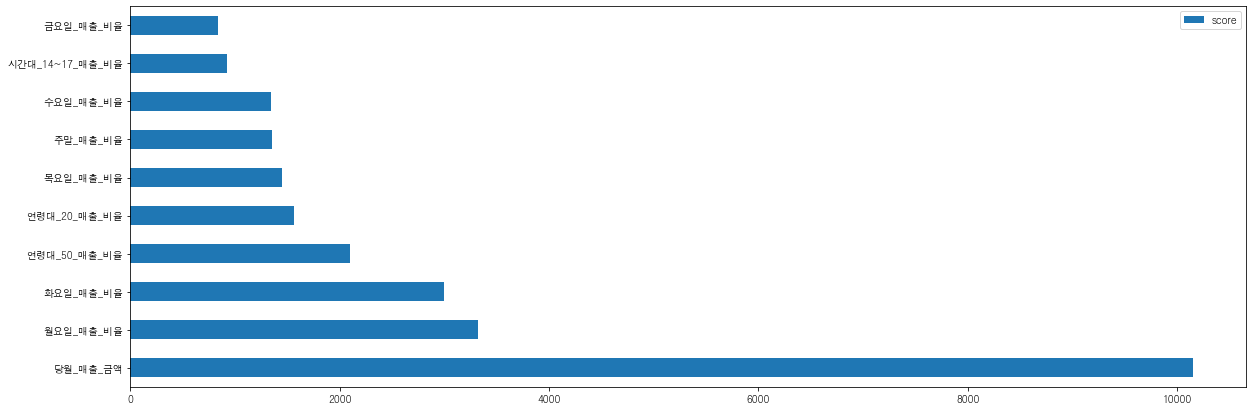

In [154]:
# 중요도 시각화

feature_important = model.get_booster().get_score(importance_type='weight')
keys = list(feature_important.keys())
values = list(feature_important.values())
plt.rcParams["figure.figsize"] = (20,7)
data_50 = pd.DataFrame(data=values, index=keys, columns=["score"]).sort_values(by = "score", ascending=False)
data_50[:10].plot(kind='barh')

## 5. 생존율 관점에서 분석하기

In [155]:
# 폐업률을 생존율로 변환

total = 100
x_out['폐업_률']=total-x_out['폐업_률']
x_out

,폐업_률
0,96
1,98
2,97
3,98
4,97
5,99
6,96
7,98
8,95
9,97


In [156]:
import time
from xgboost import XGBRegressor
from sklearn.model_selection import train_test_split
start = time.time()  # 시작 시간 저장
from sklearn.metrics import accuracy_score

# train, test 데이터 
X_train, X_test, y_train, y_test= train_test_split(x_in, x_out, test_size=0.2, random_state=42)

In [157]:
# xgboost 학습

model = XGBRegressor(booster="gbtree", objective ='reg:squarederror', n_estimators=6000, learning_rate=0.001 ,
                      max_depth=12, n_jobs = -1,subsample=0.75, reg_lambda=1, colsample_bytree=1, gamma=0, )

eval_set = [(X_test, y_test)]

model.fit(X_train,y_train, eval_set=eval_set, verbose=True)

pred_y = model.predict(X_test)

#predictions = [round(value) for value in xgb_5000_명동_pred ]
# evaluate predictions

print("time :", time.time() - start)  # 현재시각 - 시작시간 = 실행 시간

[0]	validation_0-rmse:96.41837
[1]	validation_0-rmse:96.32877
[2]	validation_0-rmse:96.23779
[3]	validation_0-rmse:96.14844
[4]	validation_0-rmse:96.05859
[5]	validation_0-rmse:95.96989
[6]	validation_0-rmse:95.88071
[7]	validation_0-rmse:95.79043
[8]	validation_0-rmse:95.70134
[9]	validation_0-rmse:95.61304
[10]	validation_0-rmse:95.52315
[11]	validation_0-rmse:95.43493
[12]	validation_0-rmse:95.34515
[13]	validation_0-rmse:95.25735
[14]	validation_0-rmse:95.16737
[15]	validation_0-rmse:95.07711
[16]	validation_0-rmse:94.99227
[17]	validation_0-rmse:94.90640
[18]	validation_0-rmse:94.81892
[19]	validation_0-rmse:94.73127
[20]	validation_0-rmse:94.64323
[21]	validation_0-rmse:94.55383
[22]	validation_0-rmse:94.46658
[23]	validation_0-rmse:94.37870
[24]	validation_0-rmse:94.29031
[25]	validation_0-rmse:94.20313
[26]	validation_0-rmse:94.11455
[27]	validation_0-rmse:94.02654
[28]	validation_0-rmse:93.94133
[29]	validation_0-rmse:93.85318
[30]	validation_0-rmse:93.76519
[31]	validation_0-

[252]	validation_0-rmse:76.28748
[253]	validation_0-rmse:76.21844
[254]	validation_0-rmse:76.14665
[255]	validation_0-rmse:76.07487
[256]	validation_0-rmse:76.00457
[257]	validation_0-rmse:75.93449
[258]	validation_0-rmse:75.86476
[259]	validation_0-rmse:75.79368
[260]	validation_0-rmse:75.72289
[261]	validation_0-rmse:75.65175
[262]	validation_0-rmse:75.58132
[263]	validation_0-rmse:75.51051
[264]	validation_0-rmse:75.43945
[265]	validation_0-rmse:75.36965
[266]	validation_0-rmse:75.29867
[267]	validation_0-rmse:75.22849
[268]	validation_0-rmse:75.15786
[269]	validation_0-rmse:75.08774
[270]	validation_0-rmse:75.01701
[271]	validation_0-rmse:74.94666
[272]	validation_0-rmse:74.87872
[273]	validation_0-rmse:74.80995
[274]	validation_0-rmse:74.73920
[275]	validation_0-rmse:74.66887
[276]	validation_0-rmse:74.59987
[277]	validation_0-rmse:74.53048
[278]	validation_0-rmse:74.46101
[279]	validation_0-rmse:74.39094
[280]	validation_0-rmse:74.32210
[281]	validation_0-rmse:74.25462
[282]	vali

[501]	validation_0-rmse:60.49030
[502]	validation_0-rmse:60.43387
[503]	validation_0-rmse:60.37689
[504]	validation_0-rmse:60.32130
[505]	validation_0-rmse:60.26585
[506]	validation_0-rmse:60.20896
[507]	validation_0-rmse:60.15250
[508]	validation_0-rmse:60.09623
[509]	validation_0-rmse:60.04017
[510]	validation_0-rmse:59.98423
[511]	validation_0-rmse:59.92844
[512]	validation_0-rmse:59.87294
[513]	validation_0-rmse:59.81622
[514]	validation_0-rmse:59.76018
[515]	validation_0-rmse:59.70407
[516]	validation_0-rmse:59.64743
[517]	validation_0-rmse:59.59119
[518]	validation_0-rmse:59.53493
[519]	validation_0-rmse:59.48037
[520]	validation_0-rmse:59.42513
[521]	validation_0-rmse:59.37058
[522]	validation_0-rmse:59.31483
[523]	validation_0-rmse:59.25934
[524]	validation_0-rmse:59.20397
[525]	validation_0-rmse:59.14954
[526]	validation_0-rmse:59.09369
[527]	validation_0-rmse:59.03945
[528]	validation_0-rmse:58.98460
[529]	validation_0-rmse:58.92941
[530]	validation_0-rmse:58.87400
[531]	vali

[750]	validation_0-rmse:47.93990
[751]	validation_0-rmse:47.89430
[752]	validation_0-rmse:47.84890
[753]	validation_0-rmse:47.80414
[754]	validation_0-rmse:47.75907
[755]	validation_0-rmse:47.71448
[756]	validation_0-rmse:47.66970
[757]	validation_0-rmse:47.62497
[758]	validation_0-rmse:47.58093
[759]	validation_0-rmse:47.53620
[760]	validation_0-rmse:47.49107
[761]	validation_0-rmse:47.44681
[762]	validation_0-rmse:47.40316
[763]	validation_0-rmse:47.35815
[764]	validation_0-rmse:47.31394
[765]	validation_0-rmse:47.26908
[766]	validation_0-rmse:47.22478
[767]	validation_0-rmse:47.17979
[768]	validation_0-rmse:47.13512
[769]	validation_0-rmse:47.09128
[770]	validation_0-rmse:47.04773
[771]	validation_0-rmse:47.00312
[772]	validation_0-rmse:46.95872
[773]	validation_0-rmse:46.91512
[774]	validation_0-rmse:46.87101
[775]	validation_0-rmse:46.82733
[776]	validation_0-rmse:46.78434
[777]	validation_0-rmse:46.74057
[778]	validation_0-rmse:46.69701
[779]	validation_0-rmse:46.65347
[780]	vali

[999]	validation_0-rmse:37.95192
[1000]	validation_0-rmse:37.91639
[1001]	validation_0-rmse:37.88037
[1002]	validation_0-rmse:37.84502
[1003]	validation_0-rmse:37.80951
[1004]	validation_0-rmse:37.77549
[1005]	validation_0-rmse:37.73961
[1006]	validation_0-rmse:37.70404
[1007]	validation_0-rmse:37.66955
[1008]	validation_0-rmse:37.63508
[1009]	validation_0-rmse:37.59909
[1010]	validation_0-rmse:37.56343
[1011]	validation_0-rmse:37.52906
[1012]	validation_0-rmse:37.49411
[1013]	validation_0-rmse:37.45928
[1014]	validation_0-rmse:37.42376
[1015]	validation_0-rmse:37.38834
[1016]	validation_0-rmse:37.35275
[1017]	validation_0-rmse:37.31762
[1018]	validation_0-rmse:37.28283
[1019]	validation_0-rmse:37.24746
[1020]	validation_0-rmse:37.21227
[1021]	validation_0-rmse:37.17712
[1022]	validation_0-rmse:37.14185
[1023]	validation_0-rmse:37.10709
[1024]	validation_0-rmse:37.07267
[1025]	validation_0-rmse:37.03721
[1026]	validation_0-rmse:37.00254
[1027]	validation_0-rmse:36.96817
[1028]	validati

[1240]	validation_0-rmse:30.25298
[1241]	validation_0-rmse:30.22480
[1242]	validation_0-rmse:30.19577
[1243]	validation_0-rmse:30.16696
[1244]	validation_0-rmse:30.13895
[1245]	validation_0-rmse:30.11143
[1246]	validation_0-rmse:30.08273
[1247]	validation_0-rmse:30.05454
[1248]	validation_0-rmse:30.02654
[1249]	validation_0-rmse:29.99857
[1250]	validation_0-rmse:29.97037
[1251]	validation_0-rmse:29.94284
[1252]	validation_0-rmse:29.91486
[1253]	validation_0-rmse:29.88699
[1254]	validation_0-rmse:29.85857
[1255]	validation_0-rmse:29.83037
[1256]	validation_0-rmse:29.80215
[1257]	validation_0-rmse:29.77424
[1258]	validation_0-rmse:29.74639
[1259]	validation_0-rmse:29.71860
[1260]	validation_0-rmse:29.69060
[1261]	validation_0-rmse:29.66237
[1262]	validation_0-rmse:29.63549
[1263]	validation_0-rmse:29.60757
[1264]	validation_0-rmse:29.58041
[1265]	validation_0-rmse:29.55285
[1266]	validation_0-rmse:29.52515
[1267]	validation_0-rmse:29.49793
[1268]	validation_0-rmse:29.47064
[1269]	validat

[1481]	validation_0-rmse:24.09546
[1482]	validation_0-rmse:24.07236
[1483]	validation_0-rmse:24.04928
[1484]	validation_0-rmse:24.02637
[1485]	validation_0-rmse:24.00372
[1486]	validation_0-rmse:23.98092
[1487]	validation_0-rmse:23.95842
[1488]	validation_0-rmse:23.93552
[1489]	validation_0-rmse:23.91265
[1490]	validation_0-rmse:23.89089
[1491]	validation_0-rmse:23.86861
[1492]	validation_0-rmse:23.84679
[1493]	validation_0-rmse:23.82417
[1494]	validation_0-rmse:23.80147
[1495]	validation_0-rmse:23.77865
[1496]	validation_0-rmse:23.75618
[1497]	validation_0-rmse:23.73347
[1498]	validation_0-rmse:23.71102
[1499]	validation_0-rmse:23.68850
[1500]	validation_0-rmse:23.66664
[1501]	validation_0-rmse:23.64442
[1502]	validation_0-rmse:23.62215
[1503]	validation_0-rmse:23.60010
[1504]	validation_0-rmse:23.57795
[1505]	validation_0-rmse:23.55548
[1506]	validation_0-rmse:23.53405
[1507]	validation_0-rmse:23.51162
[1508]	validation_0-rmse:23.48921
[1509]	validation_0-rmse:23.46675
[1510]	validat

[1722]	validation_0-rmse:19.16285
[1723]	validation_0-rmse:19.14455
[1724]	validation_0-rmse:19.12626
[1725]	validation_0-rmse:19.10787
[1726]	validation_0-rmse:19.08942
[1727]	validation_0-rmse:19.07125
[1728]	validation_0-rmse:19.05296
[1729]	validation_0-rmse:19.03471
[1730]	validation_0-rmse:19.01691
[1731]	validation_0-rmse:18.99916
[1732]	validation_0-rmse:18.98062
[1733]	validation_0-rmse:18.96236
[1734]	validation_0-rmse:18.94400
[1735]	validation_0-rmse:18.92633
[1736]	validation_0-rmse:18.90815
[1737]	validation_0-rmse:18.89050
[1738]	validation_0-rmse:18.87284
[1739]	validation_0-rmse:18.85469
[1740]	validation_0-rmse:18.83674
[1741]	validation_0-rmse:18.81854
[1742]	validation_0-rmse:18.80024
[1743]	validation_0-rmse:18.78250
[1744]	validation_0-rmse:18.76448
[1745]	validation_0-rmse:18.74662
[1746]	validation_0-rmse:18.72893
[1747]	validation_0-rmse:18.71103
[1748]	validation_0-rmse:18.69321
[1749]	validation_0-rmse:18.67522
[1750]	validation_0-rmse:18.65744
[1751]	validat

[1963]	validation_0-rmse:15.21118
[1964]	validation_0-rmse:15.19637
[1965]	validation_0-rmse:15.18182
[1966]	validation_0-rmse:15.16718
[1967]	validation_0-rmse:15.15248
[1968]	validation_0-rmse:15.13808
[1969]	validation_0-rmse:15.12378
[1970]	validation_0-rmse:15.10930
[1971]	validation_0-rmse:15.09469
[1972]	validation_0-rmse:15.08012
[1973]	validation_0-rmse:15.06550
[1974]	validation_0-rmse:15.05121
[1975]	validation_0-rmse:15.03665
[1976]	validation_0-rmse:15.02215
[1977]	validation_0-rmse:15.00737
[1978]	validation_0-rmse:14.99277
[1979]	validation_0-rmse:14.97809
[1980]	validation_0-rmse:14.96375
[1981]	validation_0-rmse:14.94925
[1982]	validation_0-rmse:14.93503
[1983]	validation_0-rmse:14.92094
[1984]	validation_0-rmse:14.90668
[1985]	validation_0-rmse:14.89226
[1986]	validation_0-rmse:14.87822
[1987]	validation_0-rmse:14.86386
[1988]	validation_0-rmse:14.84941
[1989]	validation_0-rmse:14.83501
[1990]	validation_0-rmse:14.82052
[1991]	validation_0-rmse:14.80629
[1992]	validat

[2204]	validation_0-rmse:12.05415
[2205]	validation_0-rmse:12.04236
[2206]	validation_0-rmse:12.03051
[2207]	validation_0-rmse:12.01862
[2208]	validation_0-rmse:12.00695
[2209]	validation_0-rmse:11.99531
[2210]	validation_0-rmse:11.98382
[2211]	validation_0-rmse:11.97218
[2212]	validation_0-rmse:11.96061
[2213]	validation_0-rmse:11.94885
[2214]	validation_0-rmse:11.93722
[2215]	validation_0-rmse:11.92569
[2216]	validation_0-rmse:11.91412
[2217]	validation_0-rmse:11.90253
[2218]	validation_0-rmse:11.89083
[2219]	validation_0-rmse:11.87927
[2220]	validation_0-rmse:11.86765
[2221]	validation_0-rmse:11.85627
[2222]	validation_0-rmse:11.84460
[2223]	validation_0-rmse:11.83295
[2224]	validation_0-rmse:11.82168
[2225]	validation_0-rmse:11.81039
[2226]	validation_0-rmse:11.79876
[2227]	validation_0-rmse:11.78737
[2228]	validation_0-rmse:11.77608
[2229]	validation_0-rmse:11.76450
[2230]	validation_0-rmse:11.75300
[2231]	validation_0-rmse:11.74165
[2232]	validation_0-rmse:11.73038
[2233]	validat

[2447]	validation_0-rmse:9.51676
[2448]	validation_0-rmse:9.50752
[2449]	validation_0-rmse:9.49815
[2450]	validation_0-rmse:9.48900
[2451]	validation_0-rmse:9.47980
[2452]	validation_0-rmse:9.47039
[2453]	validation_0-rmse:9.46090
[2454]	validation_0-rmse:9.45171
[2455]	validation_0-rmse:9.44238
[2456]	validation_0-rmse:9.43333
[2457]	validation_0-rmse:9.42394
[2458]	validation_0-rmse:9.41464
[2459]	validation_0-rmse:9.40535
[2460]	validation_0-rmse:9.39601
[2461]	validation_0-rmse:9.38661
[2462]	validation_0-rmse:9.37749
[2463]	validation_0-rmse:9.36823
[2464]	validation_0-rmse:9.35913
[2465]	validation_0-rmse:9.34996
[2466]	validation_0-rmse:9.34073
[2467]	validation_0-rmse:9.33166
[2468]	validation_0-rmse:9.32252
[2469]	validation_0-rmse:9.31329
[2470]	validation_0-rmse:9.30430
[2471]	validation_0-rmse:9.29519
[2472]	validation_0-rmse:9.28608
[2473]	validation_0-rmse:9.27738
[2474]	validation_0-rmse:9.26829
[2475]	validation_0-rmse:9.25908
[2476]	validation_0-rmse:9.25008
[2477]	val

[2696]	validation_0-rmse:7.45136
[2697]	validation_0-rmse:7.44390
[2698]	validation_0-rmse:7.43637
[2699]	validation_0-rmse:7.42900
[2700]	validation_0-rmse:7.42183
[2701]	validation_0-rmse:7.41450
[2702]	validation_0-rmse:7.40717
[2703]	validation_0-rmse:7.39985
[2704]	validation_0-rmse:7.39249
[2705]	validation_0-rmse:7.38504
[2706]	validation_0-rmse:7.37773
[2707]	validation_0-rmse:7.37042
[2708]	validation_0-rmse:7.36314
[2709]	validation_0-rmse:7.35569
[2710]	validation_0-rmse:7.34830
[2711]	validation_0-rmse:7.34119
[2712]	validation_0-rmse:7.33416
[2713]	validation_0-rmse:7.32713
[2714]	validation_0-rmse:7.31983
[2715]	validation_0-rmse:7.31241
[2716]	validation_0-rmse:7.30501
[2717]	validation_0-rmse:7.29777
[2718]	validation_0-rmse:7.29049
[2719]	validation_0-rmse:7.28336
[2720]	validation_0-rmse:7.27596
[2721]	validation_0-rmse:7.26870
[2722]	validation_0-rmse:7.26131
[2723]	validation_0-rmse:7.25420
[2724]	validation_0-rmse:7.24717
[2725]	validation_0-rmse:7.24009
[2726]	val

[2945]	validation_0-rmse:5.82016
[2946]	validation_0-rmse:5.81432
[2947]	validation_0-rmse:5.80846
[2948]	validation_0-rmse:5.80289
[2949]	validation_0-rmse:5.79709
[2950]	validation_0-rmse:5.79115
[2951]	validation_0-rmse:5.78569
[2952]	validation_0-rmse:5.77986
[2953]	validation_0-rmse:5.77409
[2954]	validation_0-rmse:5.76829
[2955]	validation_0-rmse:5.76257
[2956]	validation_0-rmse:5.75672
[2957]	validation_0-rmse:5.75121
[2958]	validation_0-rmse:5.74571
[2959]	validation_0-rmse:5.73995
[2960]	validation_0-rmse:5.73430
[2961]	validation_0-rmse:5.72862
[2962]	validation_0-rmse:5.72276
[2963]	validation_0-rmse:5.71702
[2964]	validation_0-rmse:5.71175
[2965]	validation_0-rmse:5.70601
[2966]	validation_0-rmse:5.70035
[2967]	validation_0-rmse:5.69451
[2968]	validation_0-rmse:5.68892
[2969]	validation_0-rmse:5.68334
[2970]	validation_0-rmse:5.67757
[2971]	validation_0-rmse:5.67179
[2972]	validation_0-rmse:5.66614
[2973]	validation_0-rmse:5.66071
[2974]	validation_0-rmse:5.65498
[2975]	val

[3194]	validation_0-rmse:4.54314
[3195]	validation_0-rmse:4.53863
[3196]	validation_0-rmse:4.53425
[3197]	validation_0-rmse:4.52946
[3198]	validation_0-rmse:4.52475
[3199]	validation_0-rmse:4.52016
[3200]	validation_0-rmse:4.51561
[3201]	validation_0-rmse:4.51090
[3202]	validation_0-rmse:4.50655
[3203]	validation_0-rmse:4.50198
[3204]	validation_0-rmse:4.49747
[3205]	validation_0-rmse:4.49294
[3206]	validation_0-rmse:4.48834
[3207]	validation_0-rmse:4.48389
[3208]	validation_0-rmse:4.47969
[3209]	validation_0-rmse:4.47527
[3210]	validation_0-rmse:4.47073
[3211]	validation_0-rmse:4.46648
[3212]	validation_0-rmse:4.46240
[3213]	validation_0-rmse:4.45781
[3214]	validation_0-rmse:4.45334
[3215]	validation_0-rmse:4.44899
[3216]	validation_0-rmse:4.44451
[3217]	validation_0-rmse:4.44010
[3218]	validation_0-rmse:4.43549
[3219]	validation_0-rmse:4.43128
[3220]	validation_0-rmse:4.42691
[3221]	validation_0-rmse:4.42249
[3222]	validation_0-rmse:4.41805
[3223]	validation_0-rmse:4.41356
[3224]	val

[3443]	validation_0-rmse:3.54713
[3444]	validation_0-rmse:3.54359
[3445]	validation_0-rmse:3.54002
[3446]	validation_0-rmse:3.53672
[3447]	validation_0-rmse:3.53323
[3448]	validation_0-rmse:3.52951
[3449]	validation_0-rmse:3.52607
[3450]	validation_0-rmse:3.52265
[3451]	validation_0-rmse:3.51911
[3452]	validation_0-rmse:3.51545
[3453]	validation_0-rmse:3.51181
[3454]	validation_0-rmse:3.50807
[3455]	validation_0-rmse:3.50458
[3456]	validation_0-rmse:3.50105
[3457]	validation_0-rmse:3.49765
[3458]	validation_0-rmse:3.49420
[3459]	validation_0-rmse:3.49056
[3460]	validation_0-rmse:3.48736
[3461]	validation_0-rmse:3.48407
[3462]	validation_0-rmse:3.48070
[3463]	validation_0-rmse:3.47723
[3464]	validation_0-rmse:3.47387
[3465]	validation_0-rmse:3.47057
[3466]	validation_0-rmse:3.46690
[3467]	validation_0-rmse:3.46352
[3468]	validation_0-rmse:3.45996
[3469]	validation_0-rmse:3.45651
[3470]	validation_0-rmse:3.45304
[3471]	validation_0-rmse:3.44978
[3472]	validation_0-rmse:3.44640
[3473]	val

[3692]	validation_0-rmse:2.77148
[3693]	validation_0-rmse:2.76868
[3694]	validation_0-rmse:2.76600
[3695]	validation_0-rmse:2.76312
[3696]	validation_0-rmse:2.76044
[3697]	validation_0-rmse:2.75769
[3698]	validation_0-rmse:2.75496
[3699]	validation_0-rmse:2.75229
[3700]	validation_0-rmse:2.74956
[3701]	validation_0-rmse:2.74706
[3702]	validation_0-rmse:2.74431
[3703]	validation_0-rmse:2.74159
[3704]	validation_0-rmse:2.73891
[3705]	validation_0-rmse:2.73625
[3706]	validation_0-rmse:2.73344
[3707]	validation_0-rmse:2.73068
[3708]	validation_0-rmse:2.72790
[3709]	validation_0-rmse:2.72528
[3710]	validation_0-rmse:2.72297
[3711]	validation_0-rmse:2.72035
[3712]	validation_0-rmse:2.71761
[3713]	validation_0-rmse:2.71517
[3714]	validation_0-rmse:2.71256
[3715]	validation_0-rmse:2.70984
[3716]	validation_0-rmse:2.70714
[3717]	validation_0-rmse:2.70457
[3718]	validation_0-rmse:2.70193
[3719]	validation_0-rmse:2.69925
[3720]	validation_0-rmse:2.69650
[3721]	validation_0-rmse:2.69411
[3722]	val

[3941]	validation_0-rmse:2.18672
[3942]	validation_0-rmse:2.18476
[3943]	validation_0-rmse:2.18281
[3944]	validation_0-rmse:2.18076
[3945]	validation_0-rmse:2.17881
[3946]	validation_0-rmse:2.17683
[3947]	validation_0-rmse:2.17485
[3948]	validation_0-rmse:2.17295
[3949]	validation_0-rmse:2.17094
[3950]	validation_0-rmse:2.16905
[3951]	validation_0-rmse:2.16702
[3952]	validation_0-rmse:2.16524
[3953]	validation_0-rmse:2.16332
[3954]	validation_0-rmse:2.16121
[3955]	validation_0-rmse:2.15933
[3956]	validation_0-rmse:2.15728
[3957]	validation_0-rmse:2.15522
[3958]	validation_0-rmse:2.15313
[3959]	validation_0-rmse:2.15116
[3960]	validation_0-rmse:2.14904
[3961]	validation_0-rmse:2.14717
[3962]	validation_0-rmse:2.14512
[3963]	validation_0-rmse:2.14308
[3964]	validation_0-rmse:2.14094
[3965]	validation_0-rmse:2.13895
[3966]	validation_0-rmse:2.13706
[3967]	validation_0-rmse:2.13503
[3968]	validation_0-rmse:2.13303
[3969]	validation_0-rmse:2.13111
[3970]	validation_0-rmse:2.12924
[3971]	val

[4190]	validation_0-rmse:1.78281
[4191]	validation_0-rmse:1.78167
[4192]	validation_0-rmse:1.78043
[4193]	validation_0-rmse:1.77900
[4194]	validation_0-rmse:1.77788
[4195]	validation_0-rmse:1.77651
[4196]	validation_0-rmse:1.77530
[4197]	validation_0-rmse:1.77392
[4198]	validation_0-rmse:1.77285
[4199]	validation_0-rmse:1.77175
[4200]	validation_0-rmse:1.77039
[4201]	validation_0-rmse:1.76929
[4202]	validation_0-rmse:1.76801
[4203]	validation_0-rmse:1.76661
[4204]	validation_0-rmse:1.76518
[4205]	validation_0-rmse:1.76380
[4206]	validation_0-rmse:1.76253
[4207]	validation_0-rmse:1.76147
[4208]	validation_0-rmse:1.76038
[4209]	validation_0-rmse:1.75923
[4210]	validation_0-rmse:1.75814
[4211]	validation_0-rmse:1.75710
[4212]	validation_0-rmse:1.75596
[4213]	validation_0-rmse:1.75485
[4214]	validation_0-rmse:1.75364
[4215]	validation_0-rmse:1.75228
[4216]	validation_0-rmse:1.75116
[4217]	validation_0-rmse:1.75023
[4218]	validation_0-rmse:1.74898
[4219]	validation_0-rmse:1.74824
[4220]	val

[4439]	validation_0-rmse:1.56702
[4440]	validation_0-rmse:1.56630
[4441]	validation_0-rmse:1.56557
[4442]	validation_0-rmse:1.56472
[4443]	validation_0-rmse:1.56433
[4444]	validation_0-rmse:1.56396
[4445]	validation_0-rmse:1.56333
[4446]	validation_0-rmse:1.56316
[4447]	validation_0-rmse:1.56247
[4448]	validation_0-rmse:1.56213
[4449]	validation_0-rmse:1.56145
[4450]	validation_0-rmse:1.56063
[4451]	validation_0-rmse:1.55978
[4452]	validation_0-rmse:1.55908
[4453]	validation_0-rmse:1.55838
[4454]	validation_0-rmse:1.55778
[4455]	validation_0-rmse:1.55747
[4456]	validation_0-rmse:1.55715
[4457]	validation_0-rmse:1.55655
[4458]	validation_0-rmse:1.55569
[4459]	validation_0-rmse:1.55486
[4460]	validation_0-rmse:1.55419
[4461]	validation_0-rmse:1.55386
[4462]	validation_0-rmse:1.55354
[4463]	validation_0-rmse:1.55323
[4464]	validation_0-rmse:1.55252
[4465]	validation_0-rmse:1.55225
[4466]	validation_0-rmse:1.55160
[4467]	validation_0-rmse:1.55093
[4468]	validation_0-rmse:1.55037
[4469]	val

[4688]	validation_0-rmse:1.45943
[4689]	validation_0-rmse:1.45911
[4690]	validation_0-rmse:1.45879
[4691]	validation_0-rmse:1.45858
[4692]	validation_0-rmse:1.45853
[4693]	validation_0-rmse:1.45806
[4694]	validation_0-rmse:1.45814
[4695]	validation_0-rmse:1.45775
[4696]	validation_0-rmse:1.45761
[4697]	validation_0-rmse:1.45755
[4698]	validation_0-rmse:1.45723
[4699]	validation_0-rmse:1.45715
[4700]	validation_0-rmse:1.45645
[4701]	validation_0-rmse:1.45654
[4702]	validation_0-rmse:1.45625
[4703]	validation_0-rmse:1.45595
[4704]	validation_0-rmse:1.45549
[4705]	validation_0-rmse:1.45510
[4706]	validation_0-rmse:1.45506
[4707]	validation_0-rmse:1.45500
[4708]	validation_0-rmse:1.45437
[4709]	validation_0-rmse:1.45387
[4710]	validation_0-rmse:1.45344
[4711]	validation_0-rmse:1.45315
[4712]	validation_0-rmse:1.45306
[4713]	validation_0-rmse:1.45260
[4714]	validation_0-rmse:1.45256
[4715]	validation_0-rmse:1.45244
[4716]	validation_0-rmse:1.45239
[4717]	validation_0-rmse:1.45235
[4718]	val

[4937]	validation_0-rmse:1.40979
[4938]	validation_0-rmse:1.40946
[4939]	validation_0-rmse:1.40929
[4940]	validation_0-rmse:1.40885
[4941]	validation_0-rmse:1.40841
[4942]	validation_0-rmse:1.40823
[4943]	validation_0-rmse:1.40789
[4944]	validation_0-rmse:1.40744
[4945]	validation_0-rmse:1.40723
[4946]	validation_0-rmse:1.40735
[4947]	validation_0-rmse:1.40703
[4948]	validation_0-rmse:1.40696
[4949]	validation_0-rmse:1.40673
[4950]	validation_0-rmse:1.40655
[4951]	validation_0-rmse:1.40638
[4952]	validation_0-rmse:1.40629
[4953]	validation_0-rmse:1.40621
[4954]	validation_0-rmse:1.40633
[4955]	validation_0-rmse:1.40619
[4956]	validation_0-rmse:1.40629
[4957]	validation_0-rmse:1.40634
[4958]	validation_0-rmse:1.40638
[4959]	validation_0-rmse:1.40650
[4960]	validation_0-rmse:1.40623
[4961]	validation_0-rmse:1.40606
[4962]	validation_0-rmse:1.40573
[4963]	validation_0-rmse:1.40557
[4964]	validation_0-rmse:1.40542
[4965]	validation_0-rmse:1.40521
[4966]	validation_0-rmse:1.40531
[4967]	val

[5186]	validation_0-rmse:1.38919
[5187]	validation_0-rmse:1.38915
[5188]	validation_0-rmse:1.38904
[5189]	validation_0-rmse:1.38905
[5190]	validation_0-rmse:1.38917
[5191]	validation_0-rmse:1.38895
[5192]	validation_0-rmse:1.38918
[5193]	validation_0-rmse:1.38915
[5194]	validation_0-rmse:1.38939
[5195]	validation_0-rmse:1.38934
[5196]	validation_0-rmse:1.38924
[5197]	validation_0-rmse:1.38905
[5198]	validation_0-rmse:1.38893
[5199]	validation_0-rmse:1.38921
[5200]	validation_0-rmse:1.38898
[5201]	validation_0-rmse:1.38909
[5202]	validation_0-rmse:1.38904
[5203]	validation_0-rmse:1.38882
[5204]	validation_0-rmse:1.38857
[5205]	validation_0-rmse:1.38860
[5206]	validation_0-rmse:1.38856
[5207]	validation_0-rmse:1.38829
[5208]	validation_0-rmse:1.38831
[5209]	validation_0-rmse:1.38805
[5210]	validation_0-rmse:1.38802
[5211]	validation_0-rmse:1.38820
[5212]	validation_0-rmse:1.38797
[5213]	validation_0-rmse:1.38817
[5214]	validation_0-rmse:1.38810
[5215]	validation_0-rmse:1.38828
[5216]	val

[5435]	validation_0-rmse:1.38161
[5436]	validation_0-rmse:1.38155
[5437]	validation_0-rmse:1.38170
[5438]	validation_0-rmse:1.38194
[5439]	validation_0-rmse:1.38184
[5440]	validation_0-rmse:1.38204
[5441]	validation_0-rmse:1.38195
[5442]	validation_0-rmse:1.38189
[5443]	validation_0-rmse:1.38209
[5444]	validation_0-rmse:1.38200
[5445]	validation_0-rmse:1.38179
[5446]	validation_0-rmse:1.38169
[5447]	validation_0-rmse:1.38192
[5448]	validation_0-rmse:1.38179
[5449]	validation_0-rmse:1.38194
[5450]	validation_0-rmse:1.38183
[5451]	validation_0-rmse:1.38198
[5452]	validation_0-rmse:1.38177
[5453]	validation_0-rmse:1.38181
[5454]	validation_0-rmse:1.38178
[5455]	validation_0-rmse:1.38162
[5456]	validation_0-rmse:1.38184
[5457]	validation_0-rmse:1.38174
[5458]	validation_0-rmse:1.38177
[5459]	validation_0-rmse:1.38172
[5460]	validation_0-rmse:1.38185
[5461]	validation_0-rmse:1.38188
[5462]	validation_0-rmse:1.38164
[5463]	validation_0-rmse:1.38160
[5464]	validation_0-rmse:1.38183
[5465]	val

[5684]	validation_0-rmse:1.38105
[5685]	validation_0-rmse:1.38139
[5686]	validation_0-rmse:1.38129
[5687]	validation_0-rmse:1.38120
[5688]	validation_0-rmse:1.38128
[5689]	validation_0-rmse:1.38115
[5690]	validation_0-rmse:1.38132
[5691]	validation_0-rmse:1.38119
[5692]	validation_0-rmse:1.38106
[5693]	validation_0-rmse:1.38086
[5694]	validation_0-rmse:1.38076
[5695]	validation_0-rmse:1.38061
[5696]	validation_0-rmse:1.38048
[5697]	validation_0-rmse:1.38023
[5698]	validation_0-rmse:1.38014
[5699]	validation_0-rmse:1.38016
[5700]	validation_0-rmse:1.38022
[5701]	validation_0-rmse:1.38054
[5702]	validation_0-rmse:1.38042
[5703]	validation_0-rmse:1.38027
[5704]	validation_0-rmse:1.38059
[5705]	validation_0-rmse:1.38085
[5706]	validation_0-rmse:1.38077
[5707]	validation_0-rmse:1.38097
[5708]	validation_0-rmse:1.38098
[5709]	validation_0-rmse:1.38081
[5710]	validation_0-rmse:1.38080
[5711]	validation_0-rmse:1.38083
[5712]	validation_0-rmse:1.38073
[5713]	validation_0-rmse:1.38097
[5714]	val

[5933]	validation_0-rmse:1.37942
[5934]	validation_0-rmse:1.37948
[5935]	validation_0-rmse:1.37978
[5936]	validation_0-rmse:1.37971
[5937]	validation_0-rmse:1.37970
[5938]	validation_0-rmse:1.37965
[5939]	validation_0-rmse:1.37968
[5940]	validation_0-rmse:1.37994
[5941]	validation_0-rmse:1.37978
[5942]	validation_0-rmse:1.37966
[5943]	validation_0-rmse:1.37949
[5944]	validation_0-rmse:1.37986
[5945]	validation_0-rmse:1.37996
[5946]	validation_0-rmse:1.37995
[5947]	validation_0-rmse:1.37993
[5948]	validation_0-rmse:1.37998
[5949]	validation_0-rmse:1.38012
[5950]	validation_0-rmse:1.38014
[5951]	validation_0-rmse:1.38016
[5952]	validation_0-rmse:1.38011
[5953]	validation_0-rmse:1.38005
[5954]	validation_0-rmse:1.38016
[5955]	validation_0-rmse:1.38011
[5956]	validation_0-rmse:1.38006
[5957]	validation_0-rmse:1.37986
[5958]	validation_0-rmse:1.38010
[5959]	validation_0-rmse:1.38013
[5960]	validation_0-rmse:1.38023
[5961]	validation_0-rmse:1.38035
[5962]	validation_0-rmse:1.38036
[5963]	val

## 6. 모델링 결과 확인
### (1) 모델 성능 시각화

### (2) Feature Importance

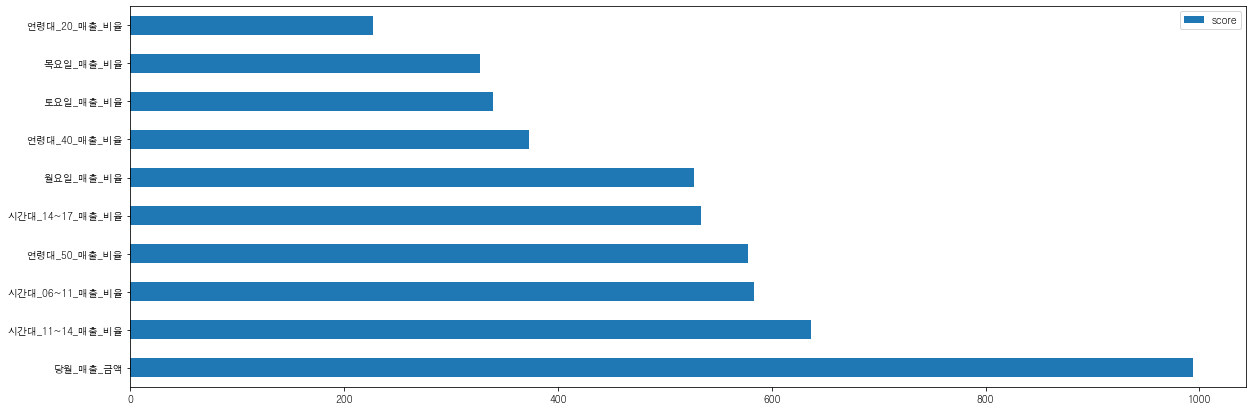

In [158]:
# 중요도 시각화

feature_important = model.get_booster().get_score(importance_type='weight')
keys = list(feature_important.keys())
values = list(feature_important.values())
plt.rcParams["figure.figsize"] = (20,7)
data_50 = pd.DataFrame(data=values, index=keys, columns=["score"]).sort_values(by = "score", ascending=False)
data_50[:10].plot(kind='barh')